In [6]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
# sys.path.insert(0, '/sphere/fangming/enhancers/scripts')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')

from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *
# from matplotlib.patches import Rectangle


import collections
import itertools
import tables
#from adjustText import adjust_text

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
# import fbpca
# import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [22]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

output_figures = '/cndd2/fangming/sphere_old/enhancers/scripts/figures/fig2_{}_{{}}'.format(today)
output_results = '/cndd2/fangming/sphere_old/enhancers/scripts/results_new/fig2_{}_{{}}'.format(today)

CORRCOEF_TYPE = 'Spearmanr' # Pearsonr

# config

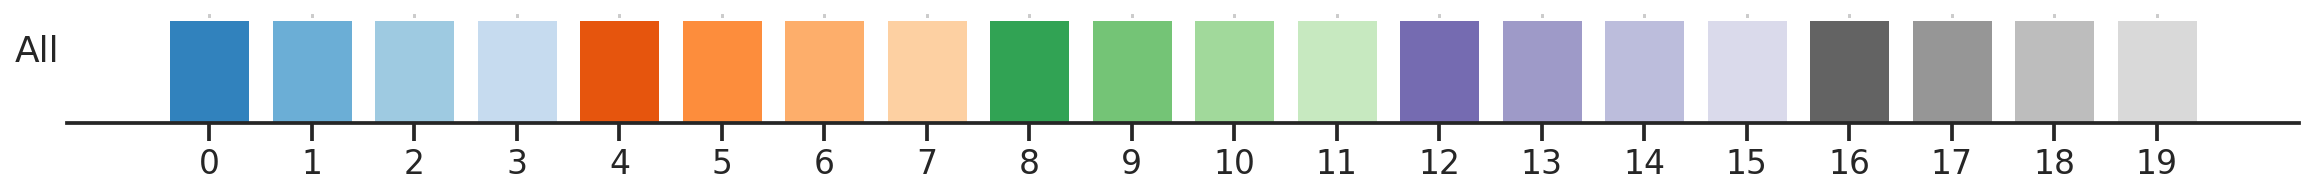

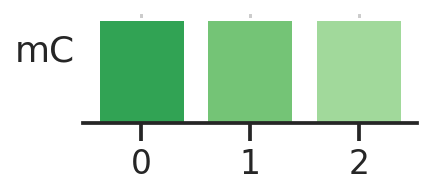

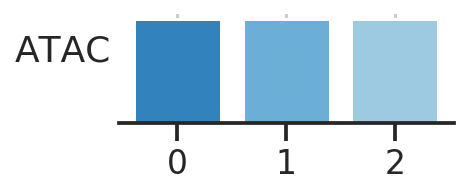

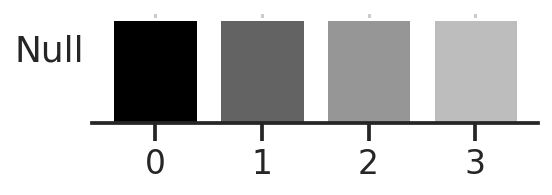

In [8]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [9]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}


KB = 1000
def p25(x):
    return np.percentile(x, 25)
def p75(x):
    return np.percentile(x, 75)


# data 

In [10]:
import pickle

"""
genes
enhancers
pairs

clusters

gene_clst_rna
gene_clst_mch
enhancer_clst_mcg
enhancer_clst_atac
"""
def tobool(x):
    """x - a string of "True"/"False"
    """
    if x == 'True':
        return True
    elif x == 'False':
        return False
    else:
        raise ValueError("?")

input_data_filename = '/cndd2/fangming/sphere_old/enhancers/scripts/data_organized/enhancer_gene_analysis_processed_data_201001.pkl'
with open(input_data_filename, 'rb') as fh:
    input_data = pickle.load(fh)
    (
        genes_list, # genes
        enh_list,
        to_evals,
        shared_clusters,
        gene_rna_clsts,
        gene_mch_clsts,
        enh_mcg_clsts,
        enh_atac_clsts,
    ) = input_data 
    
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int})#, 'is_in_genebody': bool})
to_evals['is_in_genebody'] = to_evals['is_in_genebody'].apply(tobool)

for i in input_data:
    print(i.shape, type(i))
    

(12095, 11) <class 'pandas.core.frame.DataFrame'>
(152104, 8) <class 'pandas.core.frame.DataFrame'>
(1710144, 4) <class 'pandas.core.frame.DataFrame'>
(38,) <class 'numpy.ndarray'>
(12095, 38) <class 'pandas.core.frame.DataFrame'>
(12095, 38) <class 'pandas.core.frame.DataFrame'>
(152104, 38) <class 'pandas.core.frame.DataFrame'>
(152104, 38) <class 'pandas.core.frame.DataFrame'>


In [11]:
# make a list

# gene list
dirc = '/sphere/fangming/enhancers/scripts/data_organized/'
# f = 'gene_list.txt'
# print(genes_list.shape)
# genes_list.head()
# genes_list.to_csv(dirc+f, sep='\t', header=True, index=False)

# # enh list
# f = 'enh_list.txt'
# print(enh_list.shape)
# enh_list.head()
# enh_list.to_csv(dirc+f, sep='\t', header=True, index=False)

# # pair list
# f = 'pair_list.txt'
# print(to_evals.shape)
# to_evals.head()
# to_evals.to_csv(dirc+f, sep='\t', header=True, index=False)


In [12]:
# # shared_clusters
# f = 'shared_clusters.txt'
# snmcseq_utils.export_single_textcol(dirc+f, shared_clusters)
# # pandas data tables
# f = 'gene_rna_clsts.tsv.gz'
# gene_rna_clsts.to_csv(dirc+f, sep='\t', header=True, index=True)
# # pandas data tables
# f = 'gene_mch_clsts.tsv.gz'
# gene_mch_clsts.to_csv(dirc+f, sep='\t', header=True, index=True)
# # pandas data tables
# f = 'enh_mcg_clsts.tsv.gz'
# enh_mcg_clsts.to_csv(dirc+f, sep='\t', header=True, index=True)
# # pandas data tables
# f = 'enh_atac_clsts.tsv.gz'
# enh_atac_clsts.to_csv(dirc+f, sep='\t', header=True, index=True)

In [13]:
# input_data_filename = '/sphere/fangming/enhancers/scripts/data_organized/enhancer_gene_analysis_processed_data_201001.pkl'
# fh = open(input_data_filename, 'rb')
# input_data = pickle.load(fh)

In [14]:
gid_to_gname = genes_list.groupby('gid').first()['gene_name'] 
gname_to_gid = genes_list.groupby('gene_name').first()['gid']


def gname_to_gid_nan(name):
    try:
        return gname_to_gid[name]
    except:
        return np.nan

In [15]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

In [16]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/results/enhancer_nearest_genes.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str}, 
                           names=['chr', 'start', 'end', 
                                  'trpt_chr', 'trpt_start', 'trpt_end', 
                                  'strand', 
                                  'trpt_id', 'trpt_name',
                                  'gene_id', 'gene_name',
                                  'dist',
                                 ]
                          )

print(regions_info.shape)
print(enh_list.shape)
# expand enh_list
enh_list_expand = pd.merge(enh_list, regions_info, on=['chr', 'start', 'end'], how='left')
print(enh_list_expand.shape)
enh_list_expand.head()

(233524, 12)
(152104, 8)
(152104, 17)


index   chr    start      end  clsts  length chrom   center trpt_chr  \
0      1  chr1  3112234  3112467    NaN     233     1  3112350     chr1   
1      3  chr1  3113717  3114035    NaN     318     1  3113876     chr1   
2      4  chr1  3118790  3118935    NaN     145     1  3118862     chr1   
3      5  chr1  3119286  3119396    NaN     110     1  3119341     chr1   
4      6  chr1  3121587  3121820    NaN     233     1  3121703     chr1   

  trpt_start  trpt_end strand               trpt_id    trpt_name  \
0    3102016   3102017      +  ENSMUST00000082908.1  Gm26206-201   
1    3102016   3102017      +  ENSMUST00000082908.1  Gm26206-201   
2    3102016   3102017      +  ENSMUST00000082908.1  Gm26206-201   
3    3102016   3102017      +  ENSMUST00000082908.1  Gm26206-201   
4    3102016   3102017      +  ENSMUST00000082908.1  Gm26206-201   

                gene_id gene_name   dist  
0  ENSMUSG00000064842.1   Gm26206  10218  
1  ENSMUSG00000064842.1   Gm26206  11701  
2  ENSMUSG00000064842.1   Gm26206  16774  
3  ENSMUSG00000064842.1   Gm26206  17270  
4  ENSMUSG00000064842.1   Gm26206  19571

In [17]:
# cicero pairs

## enh <-> cicero enh
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/results/enhancer_cicero_overlap.bed'
enh_cicero_overlap = pd.read_csv(f, sep='\t', 
                                 names=['chr', 'start', 'end', 
                                        'cicero_chr', 'cicero_start', 'cicero_end',
                                        'overlap',
                                       ]) 
print(enh_cicero_overlap.shape)
# restrict to the enhancers in this study
enh_cicero_overlap = pd.merge(enh_cicero_overlap, enh_list[['chr', 'start', 'end', 'index']], 
                                 on=['chr', 'start', 'end'])
print(enh_cicero_overlap.shape)


## cicero enh <-> cicero gene
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/cicero_enhancer_gene_mm10_chr.bed'
cicero_gene_links = pd.read_csv(f, sep='\t', 
                                names=['cicero_chr', 'cicero_start', 'cicero_end', 'cicero_idx', 'cicero_gene']
                               ) 
# restrict to genes in this study
cicero_gene_links['cicero_gid'] = cicero_gene_links['cicero_gene'].apply(gname_to_gid_nan)
print(cicero_gene_links.shape)
cicero_gene_links = cicero_gene_links.dropna()
print(cicero_gene_links.shape)


## merge for enh <-> gene (cicero) (register into the current gene-enh pairs (index))
enh_gene_links_cicero = pd.merge(enh_cicero_overlap, cicero_gene_links, 
                                 on=['cicero_chr', 'cicero_start', 'cicero_end'])
enh_gene_links_cicero = enh_gene_links_cicero[['index', 'cicero_gid']].rename(
                            columns={'cicero_gid': 'gene', 'index': 'enh',})
enh_gene_links_cicero = (pd.merge(enh_gene_links_cicero, to_evals[['gene', 'enh']].reset_index(), 
                                  on=['enh', 'gene']) 
                                .groupby('index').first() # remove dup 
                        )
print(enh_cicero_overlap.shape, 
      cicero_gene_links.shape, 
      enh_gene_links_cicero.shape,
     )
enh_gene_links_cicero.head()

(102287, 7)
(79223, 8)
(1283006, 6)
(674935, 6)
(79223, 8) (674935, 6) (241297, 2)


enh                gene
index                            
65     147620  ENSMUSG00000000001
68     147628  ENSMUSG00000000001
72     147634  ENSMUSG00000000001
74     147637  ENSMUSG00000000001
76     147643  ENSMUSG00000000001

# Analysis 

In [18]:
# mcg-rna
genes = genes_list['gid'].values
enhs = enh_list['index'].values.astype(int)
pairs_gene = to_evals['gene'].values
pairs_enh = to_evals['enh'].values.astype(int)

if CORRCOEF_TYPE == 'Pearsonr':
    gene_mat = gene_rna_clsts.values
    enh_mat = enh_mcg_clsts.values
elif CORRCOEF_TYPE == 'Spearmanr':
    gene_mat = gene_rna_clsts.rank(axis=1, pct=True).values
    enh_mat = enh_mcg_clsts.rank(axis=1, pct=True).values
else:
    raise ValueError('?')
    

(to_corrs, corrs, corrs_shuff, corrs_shuff_cells
) = enhancer_gene_utils.compute_enh_gene_corrs(
                    gene_mat, enh_mat,
                    genes, enhs,
                    pairs_gene, pairs_enh,
                    output_file='', 
                    verbose_level=0,
                    )

res_corrs = to_evals[to_corrs].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuff
res_corrs['corr_shuff_cells'] = corrs_shuff_cells

print(res_corrs.shape)
res_corrs.head()

pearsonr chosen!
(1710144, 7)


gene     enh    dist  is_in_genebody      corr  corr_shuff  \
0  ENSMUSG00000000001  147520  995118           False -0.416129   -0.060510   
1  ENSMUSG00000000001  147522  985740           False -0.048692    0.336908   
2  ENSMUSG00000000001  147523  983725           False -0.109531    0.164898   
3  ENSMUSG00000000001  147527  970444           False -0.134916   -0.162490   
4  ENSMUSG00000000001  147528  969372           False -0.355291   -0.144545   

   corr_shuff_cells  
0         -0.132290  
1         -0.093774  
2          0.099464  
3          0.055695  
4         -0.019368

In [19]:
# atac-rna
if CORRCOEF_TYPE == 'Pearsonr':
    gene_mat = gene_rna_clsts.values
    enh_mat = enh_atac_clsts.values
elif CORRCOEF_TYPE == 'Spearmanr':
    gene_mat = gene_rna_clsts.rank(axis=1, pct=True).values
    enh_mat = enh_atac_clsts.rank(axis=1, pct=True).values
else:
    raise ValueError('?')
    
(to_corrs, corrs, corrs_shuff, corrs_shuff_cells
) = enhancer_gene_utils.compute_enh_gene_corrs(
                    gene_mat, enh_mat,
                    genes, enhs,
                    pairs_gene, pairs_enh,
                    output_file='', 
                    verbose_level=0,
                    )

res2_corrs = to_evals[to_corrs].copy()
res2_corrs['corr'] = corrs 
res2_corrs['corr_shuff'] = corrs_shuff
res2_corrs['corr_shuff_cells'] = corrs_shuff_cells

print(res2_corrs.shape)
res2_corrs.head()

pearsonr chosen!
(1710144, 7)


gene     enh    dist  is_in_genebody      corr  corr_shuff  \
0  ENSMUSG00000000001  147520  995118           False  0.200577   -0.450170   
1  ENSMUSG00000000001  147522  985740           False -0.152726   -0.157105   
2  ENSMUSG00000000001  147523  983725           False  0.265123    0.059810   
3  ENSMUSG00000000001  147527  970444           False  0.098497   -0.346727   
4  ENSMUSG00000000001  147528  969372           False  0.100484   -0.359977   

   corr_shuff_cells  
0          0.184275  
1         -0.001752  
2         -0.064876  
3          0.073652  
4          0.072106

In [20]:
# mean pattern
n = 100
_dists = np.linspace(2*KB, 1000*KB, n)
res_corrs_median = res_corrs.groupby(pd.cut(res_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])
res2_corrs_median = res2_corrs.groupby(pd.cut(res2_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])

/cndd2/fangming/sphere_old/enhancers/scripts/figures/fig2_210108_line_corr_dist.pdf


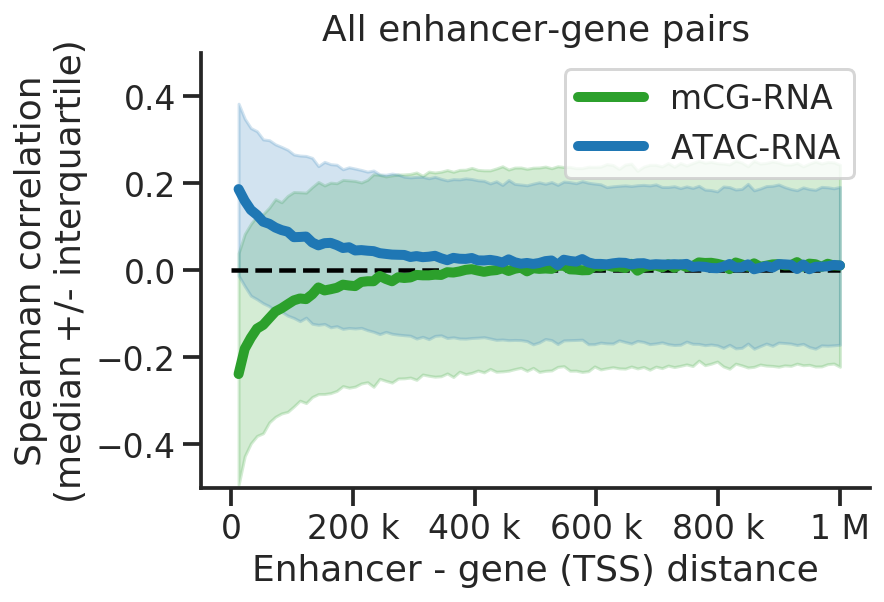

In [31]:
fig, ax = plt.subplots(figsize=(6,4))

_x = _dists[1:]
ax.hlines(0, 0, np.max(_x), linestyle='--')

_y = res_corrs_median['corr']['median'].values
_ylow = res_corrs_median['corr']['p25'].values
_yhigh = res_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='mCG-RNA',
        linewidth=5,
        color=mod_palette['mc'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['mc'], alpha=0.2, 
#                 label='mCG interquartile',
               )
sns.despine(ax=ax)

_y = res2_corrs_median['corr']['median'].values
_ylow = res2_corrs_median['corr']['p25'].values
_yhigh = res2_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='ATAC-RNA',
        linewidth=5,
        color=mod_palette['atac'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['atac'], alpha=0.2, 
#                 label='ATAC interquartile',
               )
sns.despine(ax=ax)
ax.grid(False)

ax.set_title('All enhancer-gene pairs')
ax.set_ylabel('Spearman correlation\n(median +/- interquartile)')
ax.set_xlabel('Enhancer - gene (TSS) distance')
ax.legend(bbox_to_anchor=(1,1), loc='upper right')
# ax.legend(bbox_to_anchor=(1,0), loc='lower right')
ax.xaxis.set_major_formatter(mtick.EngFormatter())
ax.set_ylim([-0.5, 0.5])

output = output_figures.format('line_corr_dist.pdf')
print(output)
fig.savefig(output, bbox_inches='tight')
plt.show()

### Statistical evaluation 

In [16]:
fdr = 0.2
dist_th = 1e5 # 100kb
pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'

res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            res_corrs['corr'],
                            res_corrs['corr_shuff'],
                            res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,201),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )
res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            res2_corrs['corr'],
                            res2_corrs['corr_shuff'],
                            res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,201),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
print(list(res_stats.keys()))
print(list(res2_stats.keys()))

['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']


In [17]:
# # save some results
# output = output_results.format('corr_results.pkl')
# print(output)

# with open(output, 'wb') as fh:
#     pickle.dump((to_evals, 
#                  res_corrs, res2_corrs, 
#                  res_stats, res2_stats,
#                 ), fh)

# save some results
output = output_results.format('linked_pairs_mc.tsv')
res_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('linked_pairs_atac.tsv')
res2_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)

output = output_results.format('correlated_pairs_mc.tsv')
res_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('correlated_pairs_atac.tsv')
res2_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)

In [18]:
output

'/sphere/fangming/enhancers/scripts/results_new/fig2_201123_correlated_pairs_atac.tsv'

# Compare with other enhancer-gene pairs

In [19]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

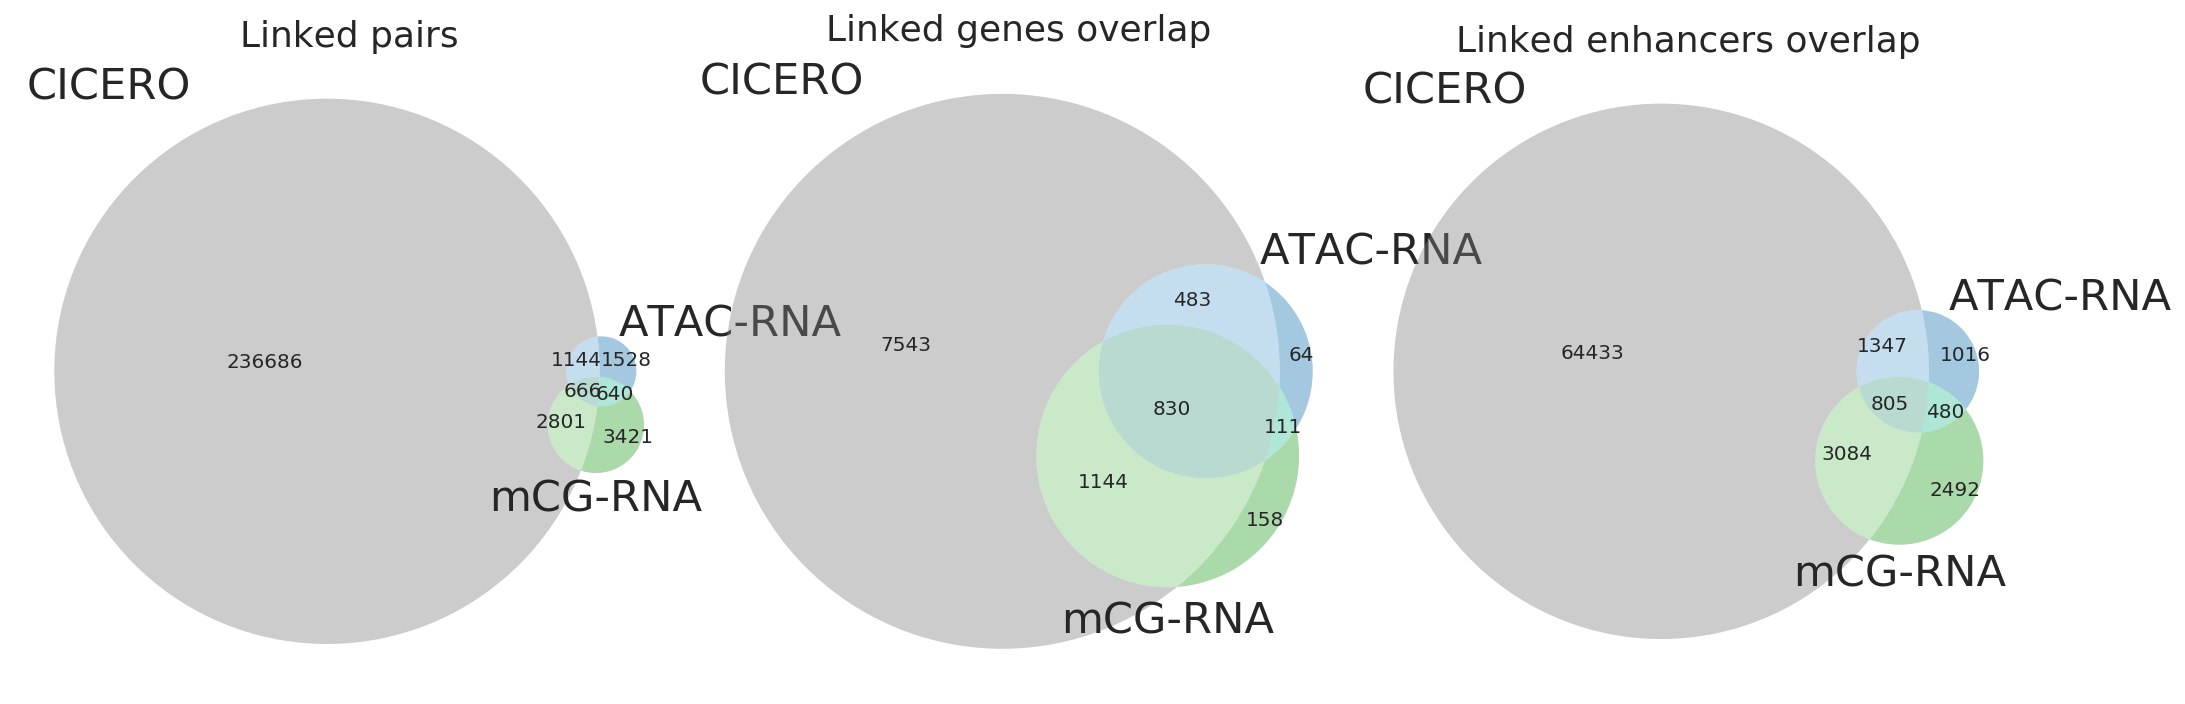

In [20]:
sets = [
    [
        set(enh_gene_links_cicero.index.values),
        set(res2_stats['linked_table'].index.values),
        set(res_stats['linked_table'].index.values), 
    ],
    [
        set(enh_gene_links_cicero['gene'].values),
        set(res2_stats['linked_table']['gene'].values),
        set(res_stats['linked_table']['gene'].values), 
    ],
    [
        set(enh_gene_links_cicero['enh'].values),
        set(res2_stats['linked_table']['enh'].values),
        set(res_stats['linked_table']['enh'].values),
    ],
]

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, label) in enumerate(zip(
    axs, ['Linked pairs', 'Linked genes overlap', 'Linked enhancers overlap'])):
    
    true_area = len(sets[i][0]|sets[i][1]|sets[i][2])
    ref_area = len(sets[0][0]|sets[0][1]|sets[0][2])
    
    out = venn3(sets[i],
                set_labels=['CICERO', 'ATAC-RNA', 'mCG-RNA'],
                set_colors=['gray', mod_palette['atac'], mod_palette['mc']],
                normalize_to=1.5,
                ax=ax
               )
    ax.set_title(label)
#     enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
    for text in out.subset_labels:
        text.set_fontsize(10)

fig.subplots_adjust(wspace=0)
fig.savefig(output_figures.format('venn_pairs_linked_cicero.pdf'), bbox_inches='tight')

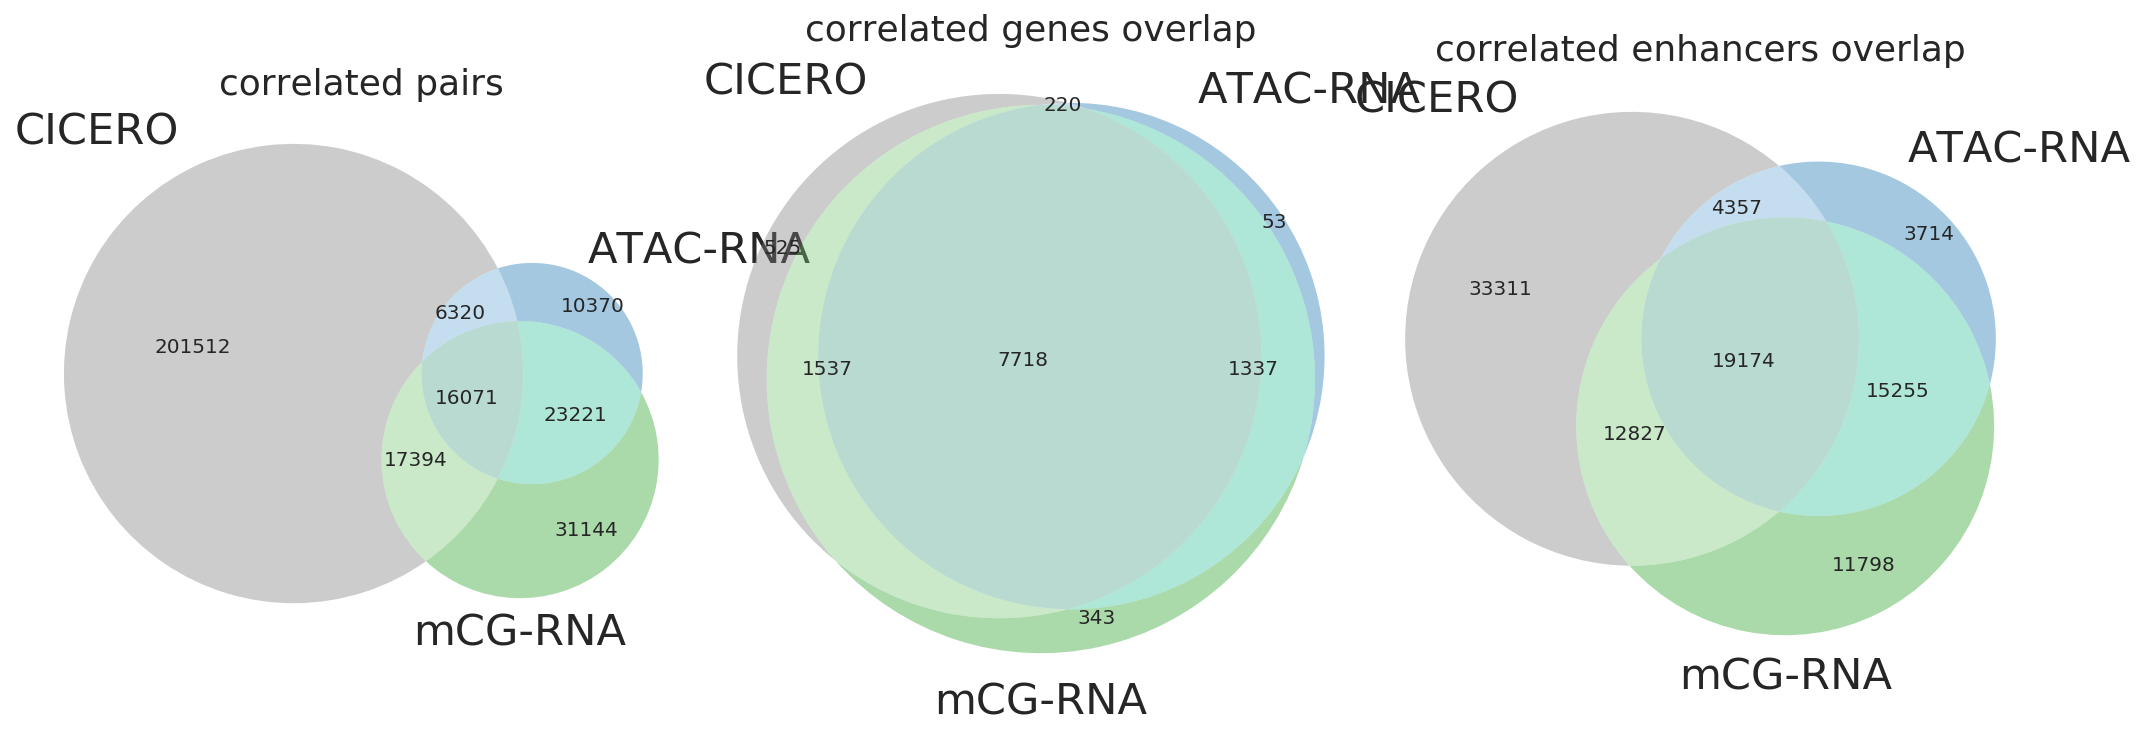

In [21]:
sets = [
    [
        set(enh_gene_links_cicero.index.values),
        set(res2_stats['correlated_table'].index.values),
        set(res_stats['correlated_table'].index.values), 
    ],
    [
        set(enh_gene_links_cicero['gene'].values),
        set(res2_stats['correlated_table']['gene'].values),
        set(res_stats['correlated_table']['gene'].values), 
    ],
    [
        set(enh_gene_links_cicero['enh'].values),
        set(res2_stats['correlated_table']['enh'].values),
        set(res_stats['correlated_table']['enh'].values),
    ],
]

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, label) in enumerate(zip(
    axs, ['correlated pairs', 'correlated genes overlap', 'correlated enhancers overlap'])):
    
    true_area = len(sets[i][0]|sets[i][1]|sets[i][2])
    ref_area = len(sets[0][0]|sets[0][1]|sets[0][2])
    
    out = venn3(sets[i],
                set_labels=['CICERO', 'ATAC-RNA', 'mCG-RNA'],
                set_colors=['gray', mod_palette['atac'], mod_palette['mc']],
                normalize_to=1.5,
                ax=ax
               )
    ax.set_title(label)
#     enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
    for text in out.subset_labels:
        try:
            text.set_fontsize(10)
        except:
            pass

    
fig.subplots_adjust(wspace=0)
fig.savefig(output_figures.format('venn_pairs_correlated_cicero.pdf'), bbox_inches='tight')

##  Test individual pairs overlaps

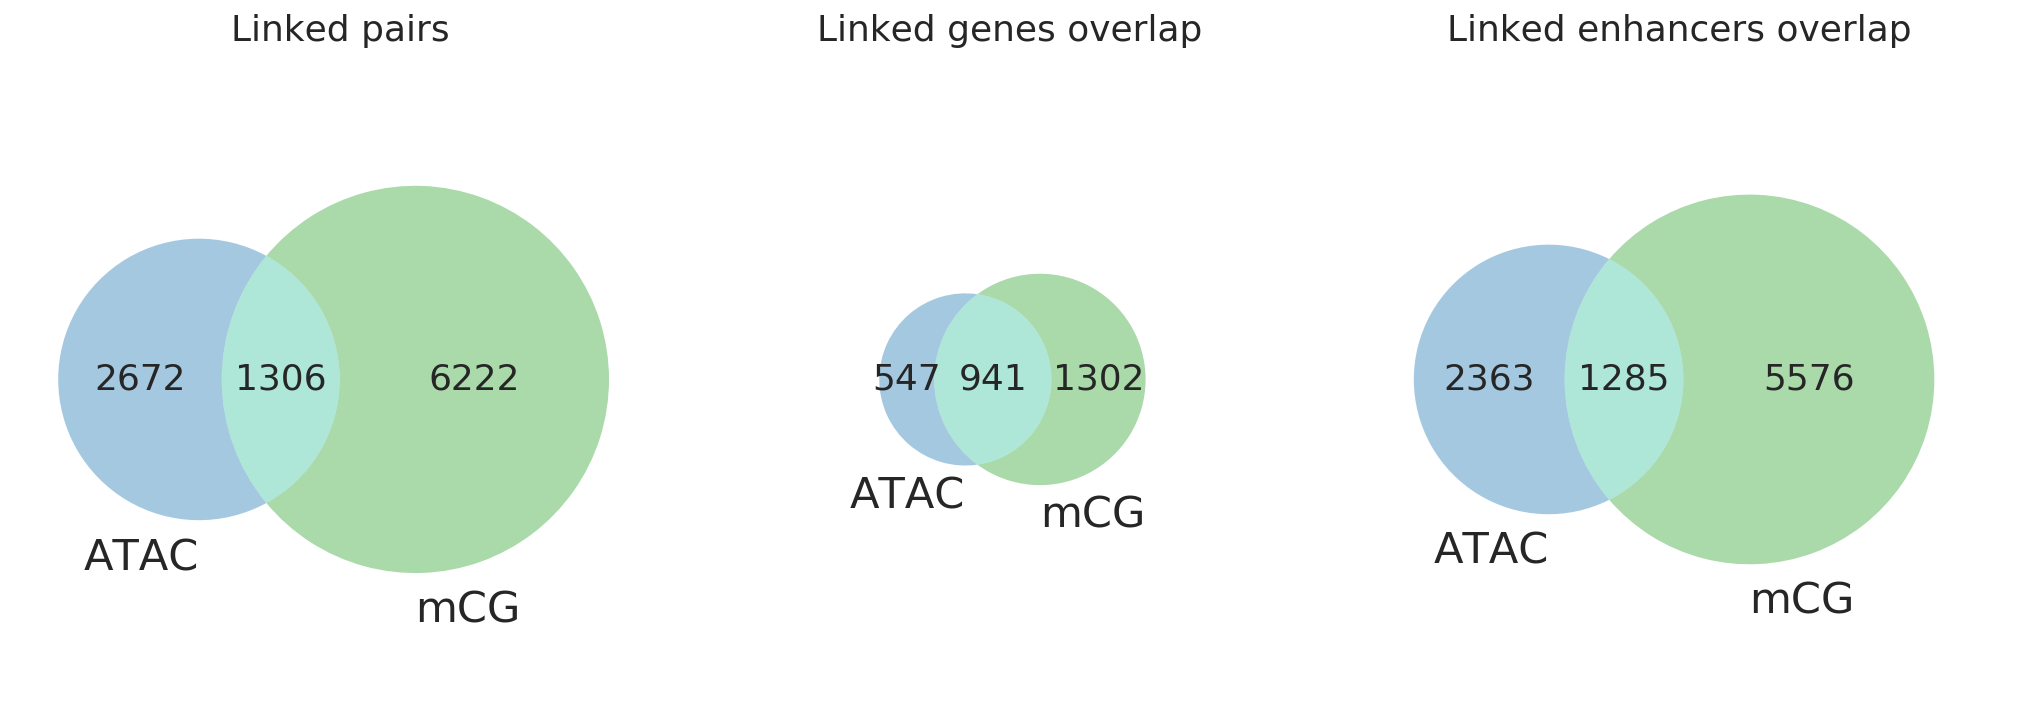

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
sets = [
    [set(res2_stats['linked_table'].index.values),
     set(res_stats['linked_table'].index.values)],
    [set(res2_stats['linked_table']['gene'].values),
     set(res_stats['linked_table']['gene'].values)],
    [set(res2_stats['linked_table']['enh'].values),
     set(res_stats['linked_table']['enh'].values)],
]

for i, (ax, label) in enumerate(zip(
    axs, ['Linked pairs', 'Linked genes overlap', 'Linked enhancers overlap'])):
    
    true_area = len(sets[i][0]|sets[i][1])
    ref_area = len(sets[0][0]|sets[0][1])
    
    venn2(sets[i],
          set_labels=['ATAC', 'mCG'],
          set_colors=[ mod_palette['atac'], mod_palette['mc']],
          normalize_to=1.5,
          ax=ax
         )
    ax.set_title(label)
    enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
fig.subplots_adjust(wspace=0)
fig.savefig(output_figures.format('ven_pairs_linked.pdf'), bbox_inches='tight')

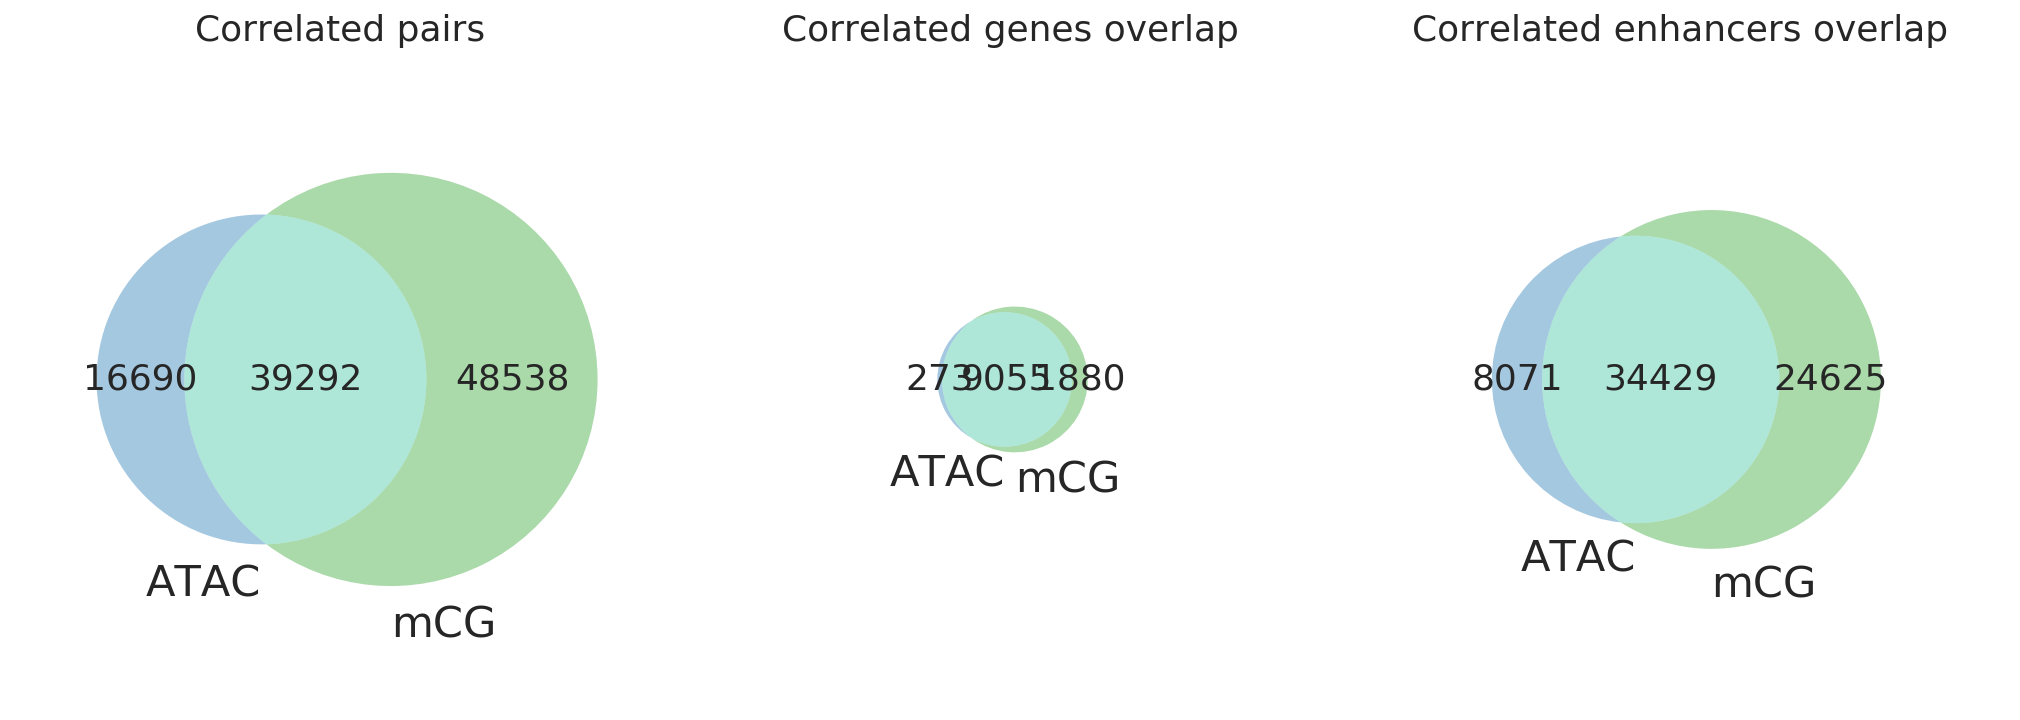

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
sets = [
    [set(res2_stats['correlated_table'].index.values),
     set(res_stats['correlated_table'].index.values)],
    [set(res2_stats['correlated_table']['gene'].values),
     set(res_stats['correlated_table']['gene'].values)],
    [set(res2_stats['correlated_table']['enh'].values),
     set(res_stats['correlated_table']['enh'].values)],
]

for i, (ax, label) in enumerate(zip(
    axs, ['Correlated pairs', 'Correlated genes overlap', 'Correlated enhancers overlap'])):
    
    true_area = len(sets[i][0]|sets[i][1])
    ref_area = len(sets[0][0]|sets[0][1])
    
    venn2(sets[i],
          set_labels=['ATAC', 'mCG'],
          set_colors=[ mod_palette['atac'], mod_palette['mc']],
          normalize_to=1.5,
          ax=ax
         )
    ax.set_title(label)
    enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
fig.subplots_adjust(wspace=0)
fig.savefig(output_figures.format('ven_pairs_correlated.pdf'), bbox_inches='tight')

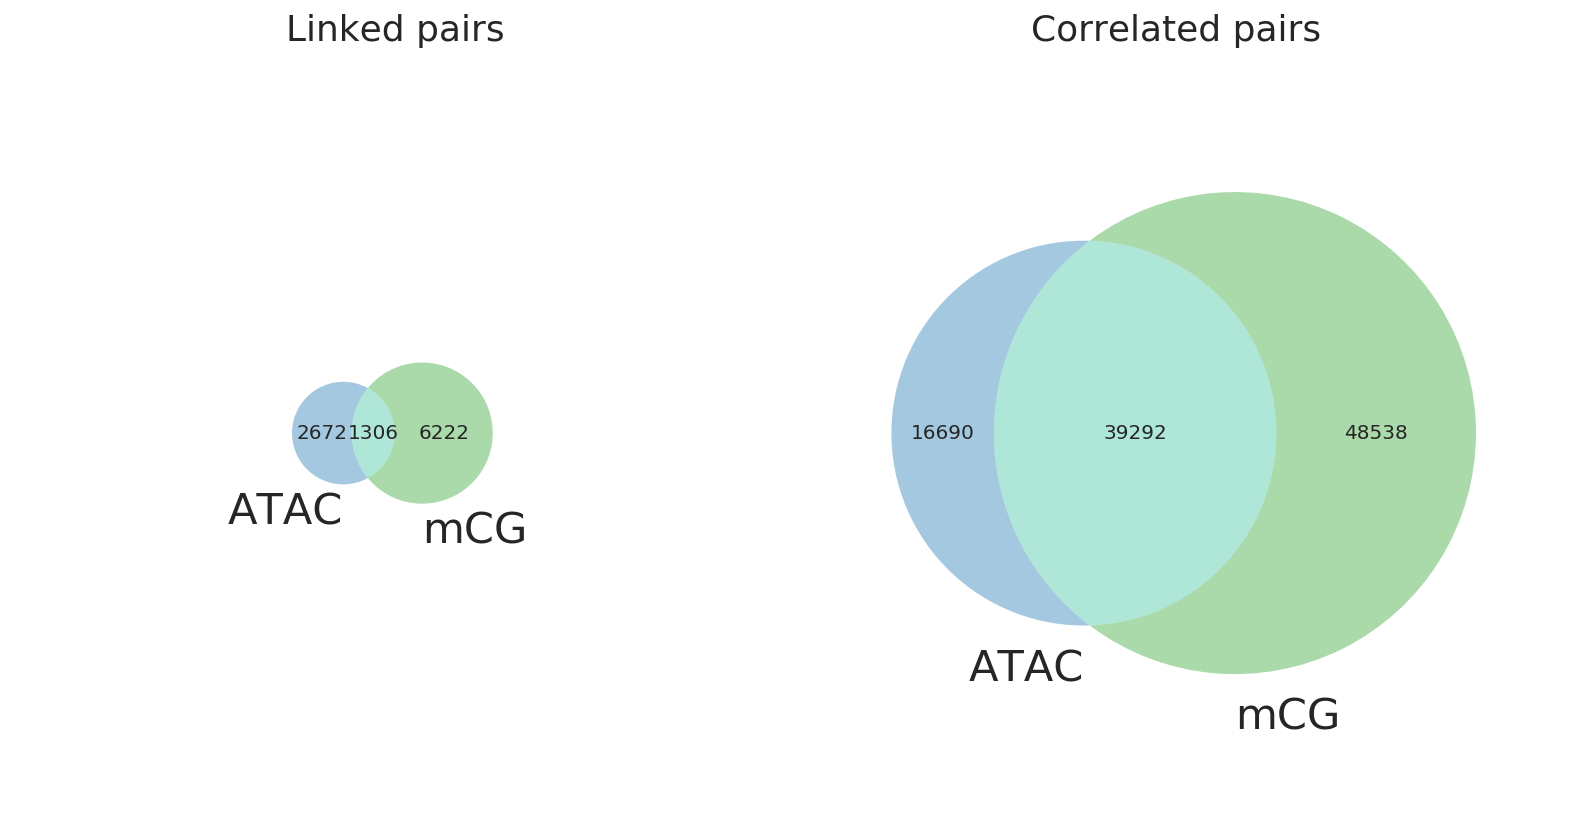

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(2*7, 1*7))
sets = [
    [set(res2_stats['linked_table'].index.values),
     set(res_stats['linked_table'].index.values)],
    [set(res2_stats['correlated_table'].index.values),
     set(res_stats['correlated_table'].index.values)],
]

for i, (ax, label) in enumerate(zip(
    axs, ['Linked pairs', 'Correlated pairs',])):
    
    true_area = len(sets[i][0]|sets[i][1])
    ref_area = len(sets[1][0]|sets[1][1])
    
    g = venn2(sets[i],
              set_labels=['ATAC', 'mCG'],
              set_colors=[ mod_palette['atac'], mod_palette['mc']],
              normalize_to=1.5,
              ax=ax
             )
    ax.set_title(label)
    enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
    for text in g.subset_labels:
        text.set_fontsize(10)
#         text.set_fontsize(int(20*np.sqrt(true_area/ref_area)))
    
fig.subplots_adjust(wspace=0)
fig.savefig(output_figures.format('ven_pairs_linkedvscorrelated.pdf'), bbox_inches='tight')

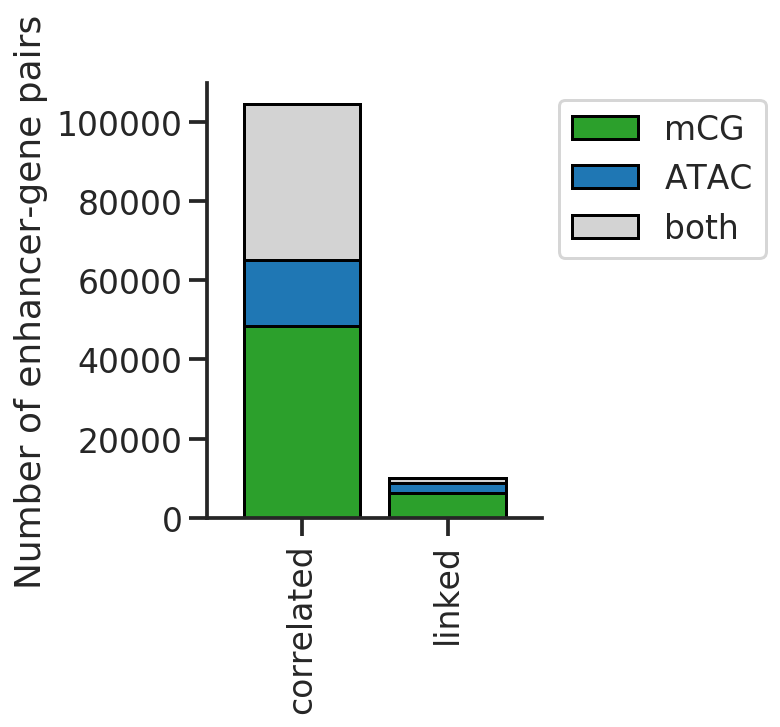

In [25]:
sets = [
    [set(res2_stats['linked_table'].index.values),
     set(res_stats['linked_table'].index.values)],
    [set(res2_stats['correlated_table'].index.values),
     set(res_stats['correlated_table'].index.values)],
]
set_union = sets[0][0] | sets[0][1] | sets[1][0] | sets[1][1]

set_pos_linked = res2_stats['linked_table'].index.values
# total pairs 
df_plot = pd.DataFrame(index=set_union)
df_plot['ATAC_linked'] = [1 if i in sets[0][0] else 0 for i in df_plot.index]
df_plot['mCG_linked'] = [1 if i in sets[0][1] else 0 for i in df_plot.index]
df_plot['ATAC_correlated'] = [1 if i in sets[1][0] else 0 for i in df_plot.index]
df_plot['mCG_correlated'] = [1 if i in sets[1][1] else 0 for i in df_plot.index]

# 
df_col1 = df_plot.groupby(['ATAC_linked', 'mCG_linked']).size()
df_col1.index = df_col1.index.values
df_col2 = df_plot.groupby(['ATAC_correlated', 'mCG_correlated']).size()
df_col2.index = df_col2.index.values
df = pd.concat([df_col1, df_col2], axis=1).rename(columns={0:'linked', 1: 'correlated'}) #.fillna(0).astype(int)
df.index = df.index.values

rename_labels = {
    (0, 0): 'None',
    (0, 1): 'mCG',
    (1, 0): 'ATAC',
    (1, 1): 'both',
}
df = df.T.head().rename(columns=rename_labels)[['mCG', 'ATAC', 'both', ]].reindex(['correlated', 'linked'])
colors = [mod_palette['mc'], mod_palette['atac'], 'lightgray', ]


with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    fig, ax = plt.subplots(figsize=(3,4))
    (df.plot.bar(stacked=True, width=0.8, color=colors, ax=ax)
    )
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    sns.despine(ax=ax)
    ax.set_ylabel('Number of enhancer-gene pairs')
    fig.savefig(output_figures.format('bar_pairs_linkedvscorrelated.pdf'), bbox_inches='tight')
    plt.show()

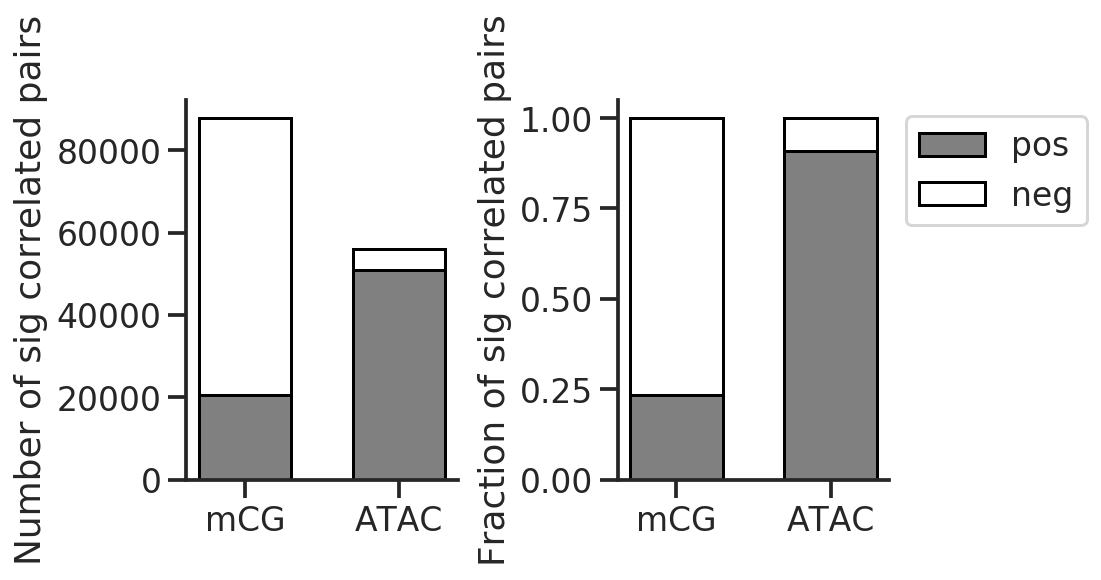

In [26]:
# numbers 
# one track is one column
_tmp = pd.merge(res_stats['correlated_table'], 
                res_corrs, on=['gene', 'enh', 'dist'],
                how='left',
               )
_tmp2 = pd.merge(res2_stats['correlated_table'], 
                 res2_corrs, on=['gene', 'enh', 'dist'],
                 how='left',
                )

track1 = [0, 
          len(_tmp[_tmp['corr']>0]),
          len(_tmp[_tmp['corr']<=0]), 
         ]
track2 = [0, 
          len(_tmp2[_tmp2['corr']>0]),
          len(_tmp2[_tmp2['corr']<=0]), 
         ]
colors = ['gray', 'white']
labels = ['pos', 'neg']
ax_labels = ['Number of sig correlated pairs', 
             'Fraction of sig correlated pairs', 
            ]
with sns.axes_style({
#                      'patch.force_edgecolor': False,
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    fig, axs = plt.subplots(1, 2, figsize=(4*2,4))
    for j, (ax, ax_label) in enumerate(zip(axs, ax_labels)):
        if j == 1:
            # normalize 
            track1 = np.array(track1)
            track1 = track1/track1.sum()

            track2 = np.array(track2)
            track2 = track2/track2.sum()

        for i in range(len(track1)-1):
            color = colors[i]
            ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=labels[i])
        for i in range(len(track2)-1):
            color = colors[i]
            ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=labels[i])

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['mCG', 'ATAC'])
        ax.set_ylabel(ax_label)
        sns.despine(ax=ax)

    snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
    # fig.suptitle('', fontsize=16)
    fig.tight_layout()

    snmcseq_utils.savefig(fig, output_figures.format('bar_frac_pos_neg.pdf'))

### Estimate frac tps
- Num significant (use the other code)

In [27]:
def estimate_frac_tps(pvalues, bin_n=100, frac_bin_null=0.20):
    """Use the median of the last 5% (frac_bin_null) of bins to estimate null level
    """
    y = np.sort(pvalues)
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = np.median(y_norm[-int(frac_bin_null*bin_n):])
    frac_tp = np.clip(1 - null_level, 0, 1)
    
    return frac_tp, null_level, bin_counts, bin_edges, y_norm
    
def plot_pval_dist(ax, frac_tp, null_level, bin_counts, bin_edges, y_norm, fillcolor='C0'):
    ax.plot(bin_edges[:-1], y_norm, color='k')
    ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
    ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                    where=y_norm>null_level, alpha=1, color=fillcolor)
    ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='lightgray')
    ax.text(0, null_level+0.2*(1-null_level), 
            "{:.1f}%".format(frac_tp*100), 
            color='white',
            fontsize=18)
    sns.despine(ax=ax)
    return ax


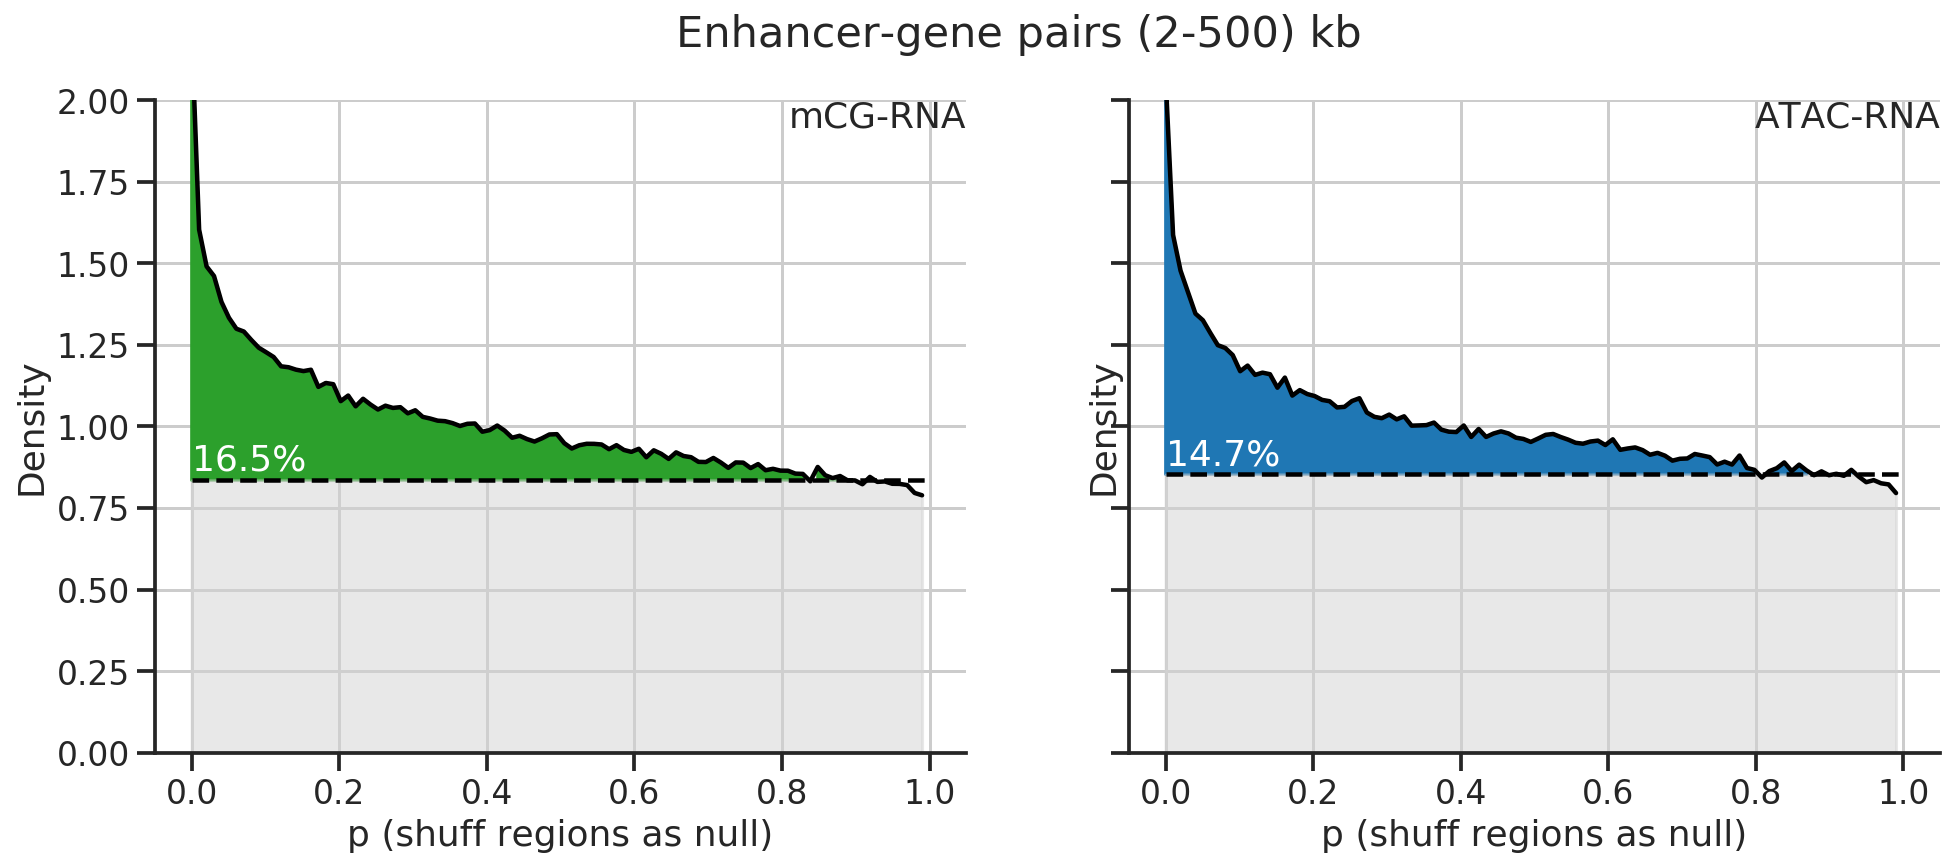

In [28]:
# plot pvalues

# analysis
ATAC_SIGN = -1

dist_th_this_plot = 5*1e5

# plot pvalues
fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
ax = axs[0]
pval = np.interp(res_corrs[res_corrs['dist']<dist_th_this_plot]['corr'], 
                     res_stats['bins'][1:], res_stats['linked_pval'])
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pval)
plot_pval_dist(ax, frac_tp, null_level, bin_counts, bin_edges, y_norm, 
               fillcolor=mod_palette['mc'],
              )
ax.set_ylim([0, 2])
ax.annotate("mCG-RNA", xy=(1,1), xycoords='axes fraction', ha='right', va='top')
ax.set_xlabel('p (shuff regions as null)')
ax.set_ylabel('Density')

ax = axs[1]
pval = np.interp(ATAC_SIGN*res2_corrs[res2_corrs['dist']<dist_th_this_plot]['corr'], 
                 res2_stats['bins'][1:], res2_stats['linked_pval'])
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pval)
plot_pval_dist(ax, frac_tp, null_level, bin_counts, bin_edges, y_norm, 
               fillcolor=mod_palette['atac'],
              )
ax.set_ylim([0, 2])
ax.annotate("ATAC-RNA", xy=(1,1), xycoords='axes fraction', ha='right', va='top')
ax.set_xlabel('p (shuff regions as null)')
ax.set_ylabel('Density')

fig.suptitle("Enhancer-gene pairs (2-500) kb")
fig.savefig(output_figures.format('hist_pval_linked.pdf'), bbox_inches='tight')
plt.show()

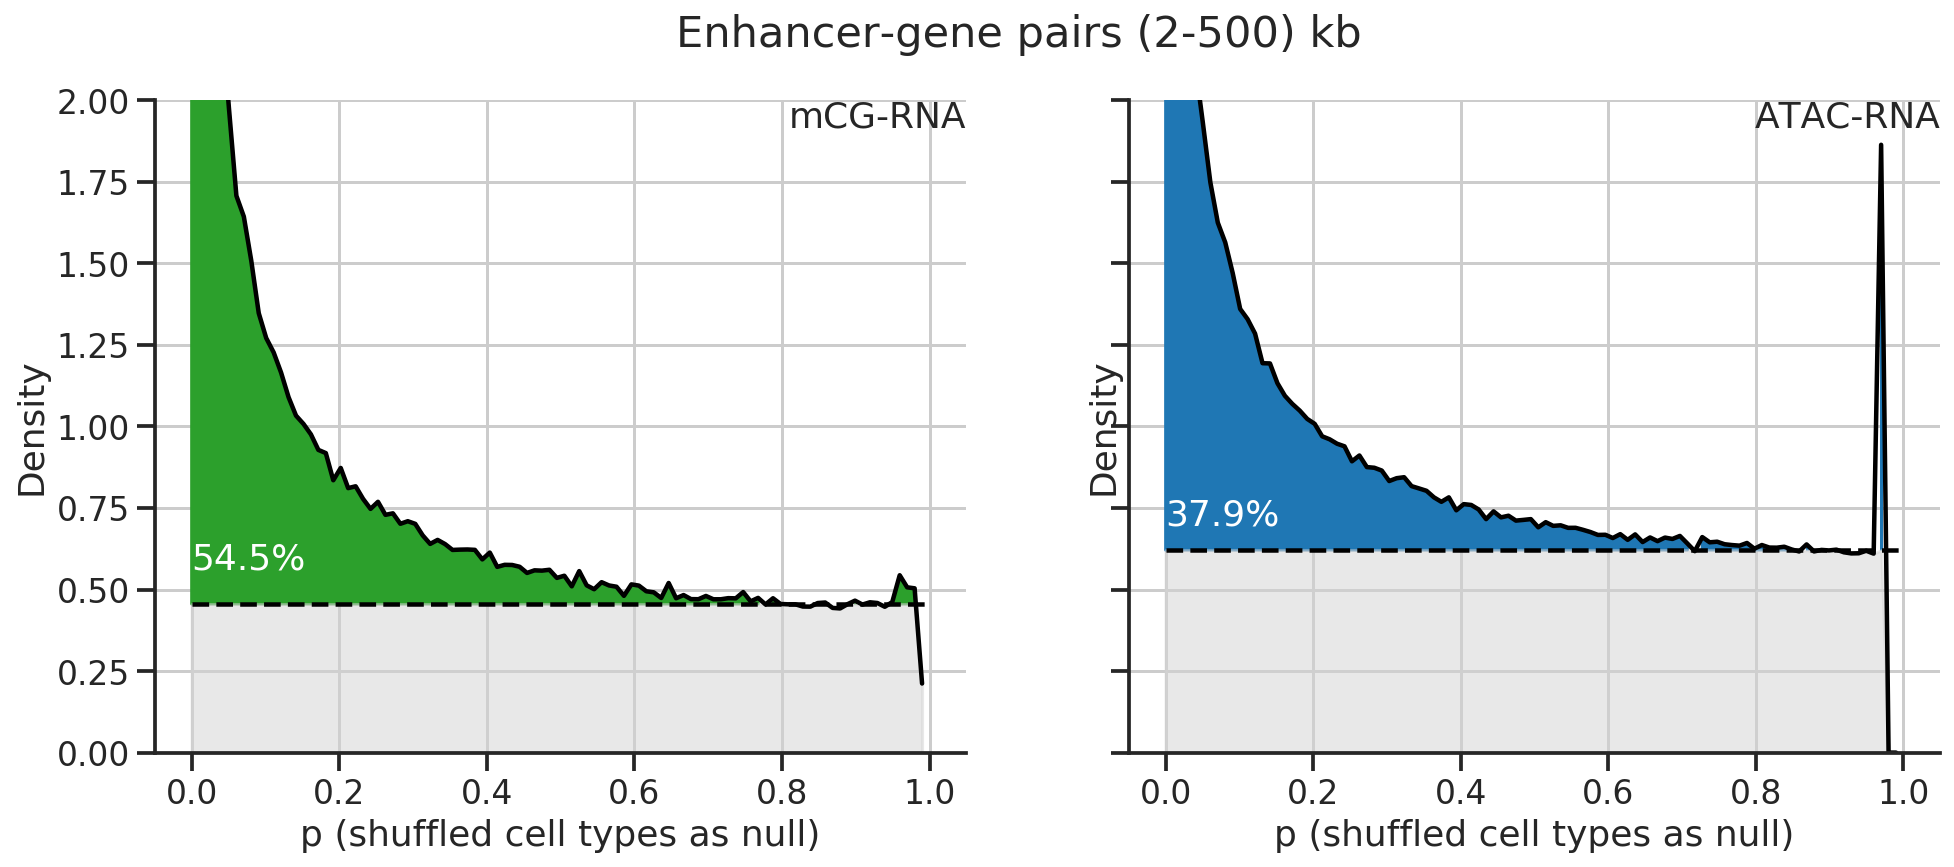

In [29]:
# plot pvalues

# analysis
ATAC_SIGN = -1

dist_th_this_plot = 5*1e5

# plot pvalues
fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
ax = axs[0]
pval = np.interp(res_corrs[res_corrs['dist']<dist_th_this_plot]['corr'], 
                 res_stats['bins'][1:], res_stats['correlated_pval'])
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pval)
plot_pval_dist(ax, frac_tp, null_level, bin_counts, bin_edges, y_norm, 
               fillcolor=mod_palette['mc'],
              )
ax.set_ylim([0, 2])
ax.annotate("mCG-RNA", xy=(1,1), xycoords='axes fraction', ha='right', va='top')
ax.set_xlabel('p (shuffled cell types as null)')
ax.set_ylabel('Density')

ax = axs[1]
pval = np.interp(ATAC_SIGN*res2_corrs[res2_corrs['dist']<dist_th_this_plot]['corr'], 
                 res2_stats['bins'][1:], res2_stats['correlated_pval'])
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pval)
plot_pval_dist(ax, frac_tp, null_level, bin_counts, bin_edges, y_norm, 
               fillcolor=mod_palette['atac'],
              )
ax.set_ylim([0, 2])
ax.annotate("ATAC-RNA", xy=(1,1), xycoords='axes fraction', ha='right', va='top')
ax.set_xlabel('p (shuffled cell types as null)')
ax.set_ylabel('Density')

fig.suptitle("Enhancer-gene pairs (2-500) kb")
fig.savefig(output_figures.format('hist_pval_correlated.pdf'), bbox_inches='tight')
plt.show()

In [30]:
def quantile_norm(array):
    return pd.Series(array).rank(pct=True, method='average').values

def estimate_frac_tps_vs_dists(dists_kb, res_corrs, res_stats, link_type, FLIP_CORR_SIGN):
    """Estimate the fraction of true positives with many different distance segments
    """
    frac_tps = []
    num_tps = []
    total_nums = []
    for idx in np.arange(len(dists_kb)):
        dist_kb = dists_kb[idx]
        if idx == 0:
            cond = (res_corrs['dist'] < dist_kb*KB)
        else:
            dist_kb_prev = dists_kb[idx-1]
            cond = ((res_corrs['dist'] < dist_kb*KB) & 
                    (res_corrs['dist'] >= dist_kb_prev*KB))

        if FLIP_CORR_SIGN: 
            corr_sign = -1
        else:
            corr_sign = 1

        pval = np.interp(corr_sign*res_corrs[cond]['corr'], 
                                res_stats['bins'][1:], res_stats[link_type])
        frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pval)
        frac_tps.append(frac_tp)
        total_nums.append(len(pval))
        num_tps.append(len(pval)*frac_tp)
    return dists_kb, frac_tps, num_tps, total_nums

def estimate_num_sigs_vs_dists(fdr_th, dists_kb, res_corrs, res_stats, link_type, FLIP_CORR_SIGN):
    """Estimate the number of significant pairs with many different distance segments
    """
    frac_tps = []
    num_tps = []
    total_nums = []
    
    sig_gene_set = set()
    cum_sig_genes = []
    
    for idx in np.arange(len(dists_kb)):
        dist_kb = dists_kb[idx]
        if idx == 0:
            cond = (res_corrs['dist'] < dist_kb*KB)
        else:
            dist_kb_prev = dists_kb[idx-1]
            cond = ((res_corrs['dist'] < dist_kb*KB) & 
                    (res_corrs['dist'] >= dist_kb_prev*KB))

        if FLIP_CORR_SIGN: 
            corr_sign = -1
        else:
            corr_sign = 1

        pval = np.interp(corr_sign*res_corrs[cond]['corr'], 
                                res_stats['bins'][1:], res_stats[link_type])
        fdr = pval/quantile_norm(pval)
        
        total_num = len(pval)
        total_nums.append(total_num)
        
        sig_cond = fdr<fdr_th
        sig_genes = res_corrs[cond][sig_cond]['gene']
        sig_gene_set = sig_gene_set.union(set(list(sig_genes.values)))
        cum_sig_gene = len(sig_gene_set)
        cum_sig_genes.append(cum_sig_gene)
        
        num_tp = sig_cond.sum()
        num_tps.append(num_tp)
        
        frac_tp = num_tp/total_num
        frac_tps.append(frac_tp)
        
        
    return dists_kb, frac_tps, num_tps, total_nums, cum_sig_genes

In [31]:
# calc
dist_begin_kb = 2
dist_binsize = 20
fdr_th = fdr
dists_kb = np.hstack(np.arange(20, 1000+1, dist_binsize))
dists_kb_plot = np.hstack([[dist_begin_kb], dists_kb])

inputs = [
    (res_corrs, res_stats, 'linked_pval', False),
    (res2_corrs, res2_stats, 'linked_pval', True),
    (res_corrs, res_stats, 'correlated_pval', False),
    (res2_corrs, res2_stats, 'correlated_pval', True),
]
df_plots = []

for _input in inputs:
    
    _res_corrs, _res_stats, link_type, _flip = _input
    dists_kb, frac_tps, num_tps, total_nums = estimate_frac_tps_vs_dists(
            dists_kb, _res_corrs, _res_stats, 
            link_type,
            FLIP_CORR_SIGN=_flip)
    
    dists_kb, sig_frac_tps, sig_num_tps, sig_total_nums, cum_sig_genes = estimate_num_sigs_vs_dists(
            fdr_th, dists_kb, _res_corrs, _res_stats, 
            link_type,
            FLIP_CORR_SIGN=_flip)
    
    # organize results
    mats = np.vstack([
                dists_kb, 
                frac_tps, num_tps, total_nums,
                sig_frac_tps, sig_num_tps, sig_total_nums, cum_sig_genes,
                ]).T 
    cols = ['dist', 
            'frac_tp', 'num_pos', 'num_total', 
            'sig_frac_tp', 'sig_num_pos', 'sig_num_total', 'cum_sig_genes',
           ] 
    df_plot = pd.DataFrame(mats, columns=cols) 
#     df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
#     df_plot['num_pos_norm'] = df_plot['num_pos']/df_plot['length']
#     df_plot['sig_num_pos_norm'] = df_plot['sig_num_pos']/df_plot['length']
    
    df_plots.append(df_plot)

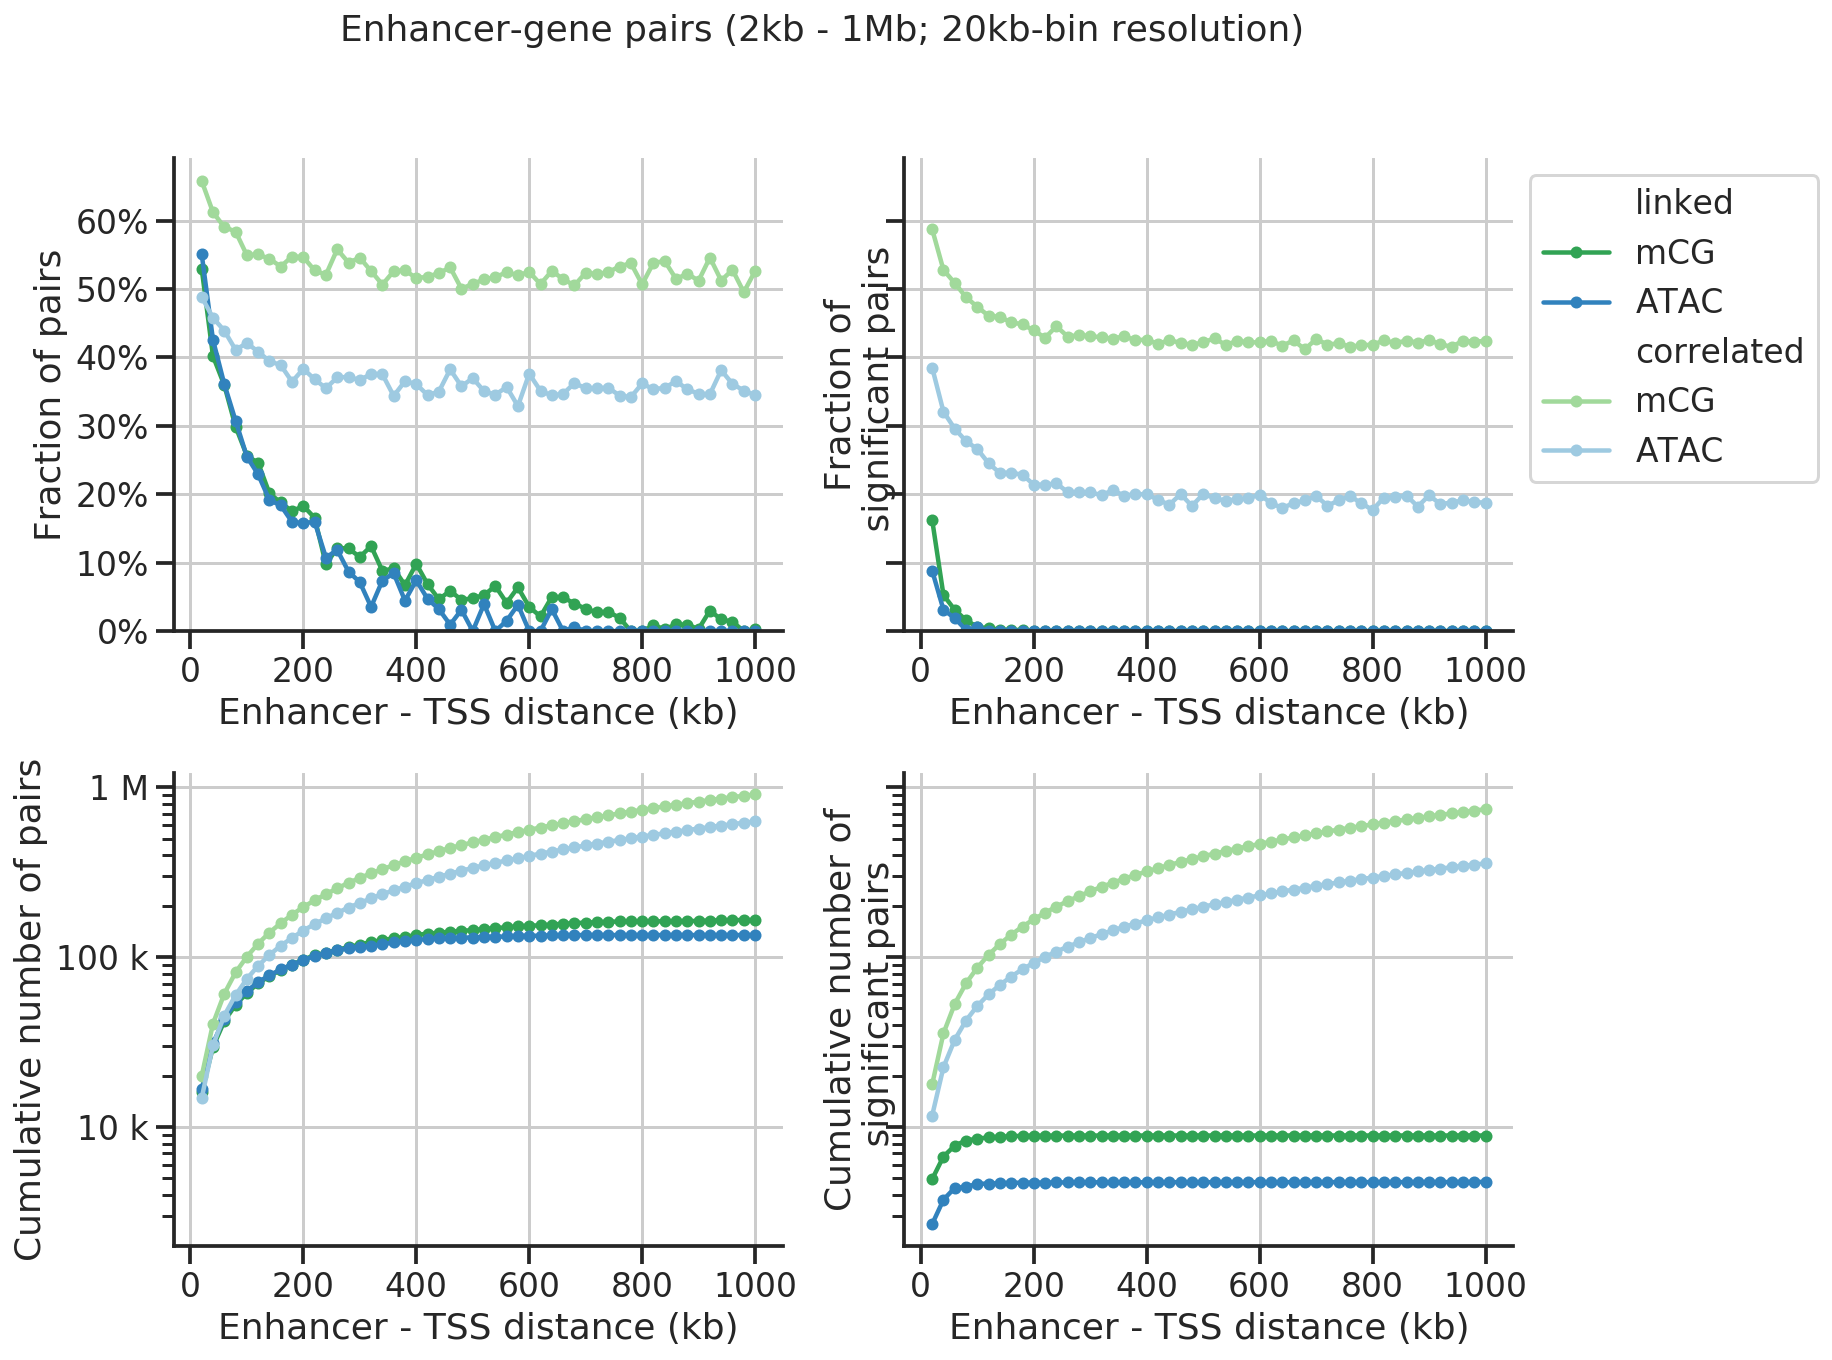

In [32]:
# prep

# one plot
colors = [
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    mod_palette_comp['mc'][2], mod_palette_comp['atac'][2], 
    ]
labels = [
    'mCG linked', 'ATAC linked', 
    'mCG correlated', 'ATAC correlated', 
    ]

# all plots
subplot_cols = [
    'frac_tp', 
    'sig_frac_tp', 
    
    'num_pos',
    'sig_num_pos',
]
subplot_labels = [
    'Fraction of pairs', 
    'Fraction of\n significant pairs', 
    
    'Cumulative number of pairs',
    'Cumulative number of\n significant pairs',
    ]
tracks_all = [
    [(df_plot['dist'], df_plot[subplot_cols[0]]) for df_plot in df_plots],
    [(df_plot['dist'], df_plot[subplot_cols[1]]) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[2]])) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[3]])) for df_plot in df_plots],
]

# plot
fig, axs = plt.subplots(2, 2, figsize=(6*2,5*2), sharex=False, sharey='row')
r = EMPTY_RECTANGLE
for i, (ax, tracks_subplot, subplot_label) in enumerate(zip(
        axs.flat, tracks_all, subplot_labels)):
    for track, color, label in zip(tracks_subplot, colors, labels):
        _x, _y = track
        ax.plot(_x, _y, '-o', color=color, label=label, markersize=5)
        
    sns.despine(ax=ax)
    ax.set_xlabel('Enhancer - TSS distance (kb)')
    ax.set_ylabel(subplot_label)
    if i in [0, 1]:
        ax.set_ylim(ymin=0)
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
    if i in [2, 3]:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(mtick.EngFormatter()) 

# work on legends
handles, labels = ax.get_legend_handles_labels()
labels = [label.split(' ')[0] for label in labels]
handles = [r] + handles[:2] + [r] + handles[2:]
labels = ['linked'] + labels[:2] + ['correlated'] + labels[2:]
axs.flat[1].legend(handles, labels, 
                      bbox_to_anchor=(1,1), loc='upper left', 
                     )
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Enhancer-gene pairs (2kb - 1Mb; {}kb-bin resolution)'.format(dist_binsize), 
             fontsize=18,
            )
fig.savefig(output_figures.format('plot_stats_vs_dist.pdf'), bbox_inches='tight')
plt.show()

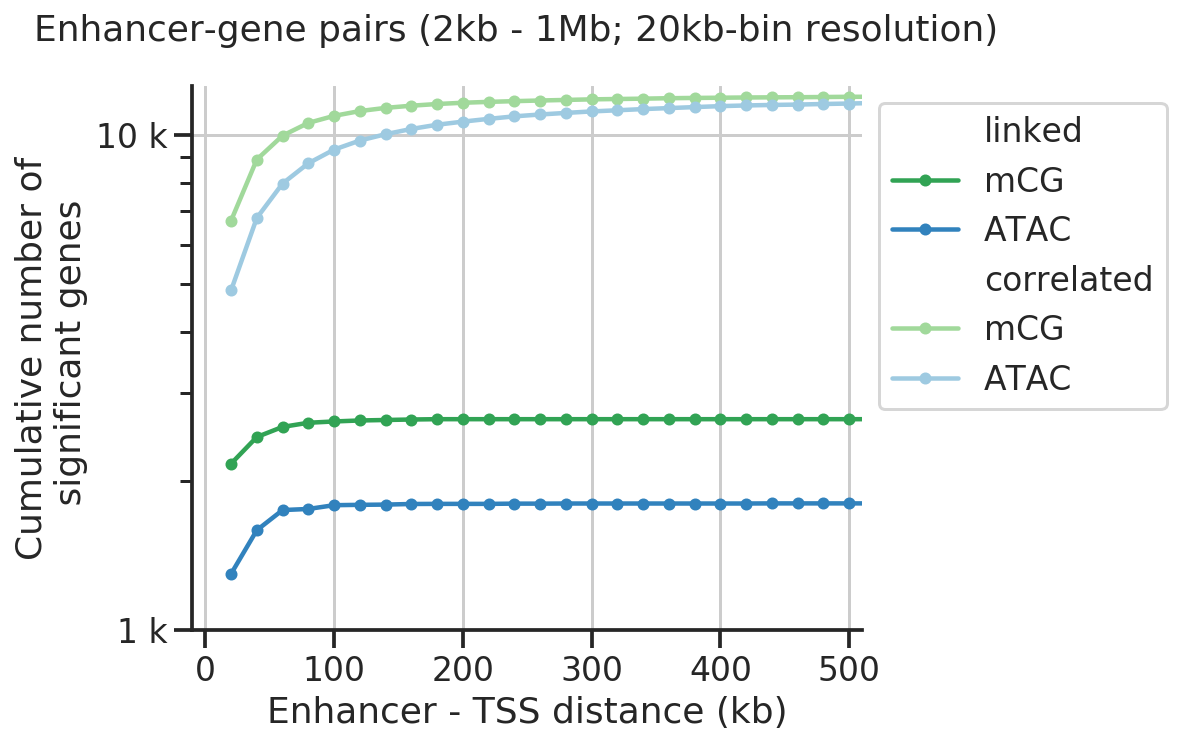

In [33]:
# prep

# one plot
colors = [
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    mod_palette_comp['mc'][2], mod_palette_comp['atac'][2], 
    ]
labels = [
    'mCG linked', 'ATAC linked', 
    'mCG correlated', 'ATAC correlated', 
    ]

# all plots
subplot_cols = [
    'cum_sig_genes',
]
subplot_labels = [
    'Cumulative number of\n significant genes',
    ]
tracks_all = [
    [(df_plot['dist'], df_plot[subplot_col]) for df_plot in df_plots]
    for subplot_col in subplot_cols
]

# plot
fig, axs = plt.subplots(1, 1, figsize=(6,5))
r = EMPTY_RECTANGLE
for i, (ax, tracks_subplot, subplot_label) in enumerate(zip(
        [axs], tracks_all, subplot_labels)):
    for track, color, label in zip(tracks_subplot, colors, labels):
        _x, _y = track
        ax.plot(_x, _y, '-o', color=color, label=label, markersize=5)
        
    sns.despine(ax=ax)
    ax.set_xlabel('Enhancer - TSS distance (kb)')
    ax.set_ylabel(subplot_label)
    ax.set_xlim(xmin=-10, xmax=510)
    ax.set_ylim(ymin=1000)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mtick.EngFormatter()) 

# work on legends
handles, labels = ax.get_legend_handles_labels()
labels = [label.split(' ')[0] for label in labels]
handles = [r] + handles[:2] + [r] + handles[2:]
labels = ['linked'] + labels[:2] + ['correlated'] + labels[2:]
ax.legend(handles, labels, 
                      bbox_to_anchor=(1,1), loc='upper left', 
                     )
# fig.subplots_adjust(wspace=0.2)
fig.suptitle('Enhancer-gene pairs (2kb - 1Mb; {}kb-bin resolution)'.format(dist_binsize), 
             fontsize=18,
            )
fig.savefig(output_figures.format('plot_cumsig_gene_vs_dist.pdf'), bbox_inches='tight')
plt.show()

### Plot corr dist

In [34]:
labels_base = [
          'shuffled cell types',
          'shuffled regions',
          '<500kb',
          '<100kb',
         ] 
subsample_rates = [
                  1,
                  1,
                  1,
                  1,
                 ]


# corr1
labels = [label+' mCG-RNA' for label in labels_base]
corr_tracks = [
       res_corrs['corr_shuff_cells'].values,
       res_corrs['corr_shuff'].values,
       res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
       res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
    
#        corr.flatten(),
#        corr_cis,
      ]
colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
vertical_lines = [
    res_stats['r_th_linked'],
    res_stats['r_th_correlated_left'],
    res_stats['r_th_correlated_right'],
]

# corr2
labels2 = [label+' ATAC-RNA' for label in labels_base]
corr_tracks2 = [
       res2_corrs['corr_shuff_cells'].values,
       res2_corrs['corr_shuff'].values,
       res2_corrs.loc[res2_corrs['dist']<=500*KB, 'corr'].values,
       res2_corrs.loc[res2_corrs['dist']<=100*KB, 'corr'].values,
    
#        corr.flatten(),
#        corr_cis,
      ]
colors2 = [colors_null[1], colors_null[0], colors_atac[1], colors_atac[0],]
vertical_lines2 = [
    ATAC_SIGN*res2_stats['r_th_linked'],
    ATAC_SIGN*res2_stats['r_th_correlated_left'],
    ATAC_SIGN*res2_stats['r_th_correlated_right'],
]

np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]
corr_tracks2 = [corr_tracks2[i][np.random.rand(len(corr_tracks2[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks2))]


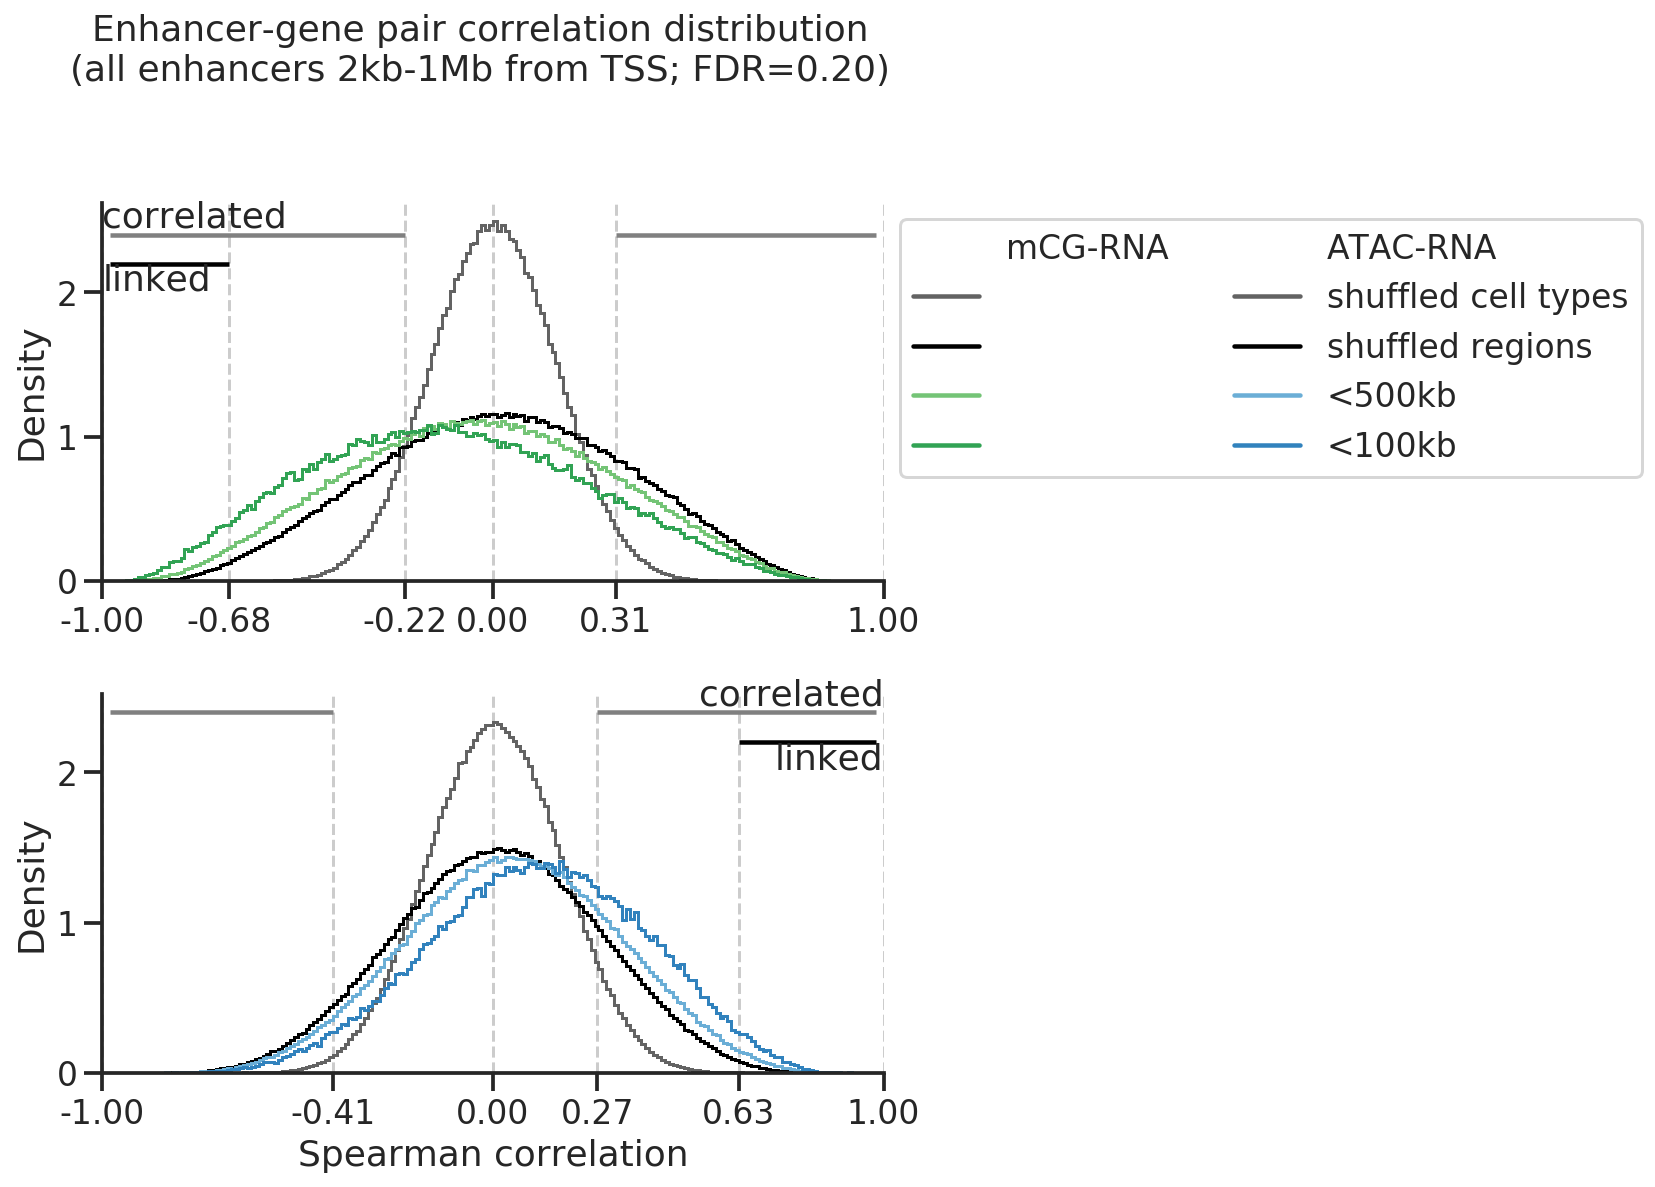

In [35]:

with sns.axes_style('ticks', {'axes.grid': False}):
    fig, axs = plt.subplots(2, 1, figsize=(7*1,4*2), sharex=False)
    for i, ax in enumerate(axs):
        ax.grid(which='major', axis='x', linestyle='--')
        if i == 0:
            _colors = colors
            _corr_tracks = corr_tracks
            _labels = labels
            _vertical_lines = vertical_lines
        elif i == 1:
            _colors = colors2
            _corr_tracks = corr_tracks2
            _labels = labels2
            _vertical_lines = vertical_lines2

        # each line (color) is present in all columns; loop over lines
        ax = axs[i]
        for j, (_x, label, color, subsample_rate) in enumerate(zip(
                _corr_tracks, _labels, _colors, subsample_rates)):
            # go over columns
            label_comp = '{} ({}, frac={})'.format(label, len(_x), subsample_rate)

            g = ax.hist(_x, bins=np.linspace(-1, 1, 201), 
                        histtype='step', 
                        label=label,
                        color=color, density=True)
            histy, histx, _ = g
            if j == 0:
                histy_first = histy

        # labels
        if i == 1:
            ax.set_xlabel('Spearman correlation')
        ax.set_ylabel('Density')
        ax.set_xlim([-1, 1])
        sns.despine(ax=ax)

        # line ticks
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2f}'))
        ax.set_xticks(np.sort(np.hstack([[-1, 0, 1], _vertical_lines])))

        # horizontal lines
        lineys = [2.2, 2.4, 2.4]
        linecolors = ['k', 'gray', 'gray']
        for xcoord, linecolor, liney in zip(_vertical_lines, linecolors, lineys):
            if xcoord < 0:
                xmin, xmax = -0.98, xcoord
            else:
                xmin, xmax = xcoord, 0.98

            ax.hlines(liney, xmin=xmin, xmax=xmax, color=linecolor, linestyle='-')

        # vertical line annotate 
        fontsize = ax.xaxis.label.get_fontsize()
        if i == 0:
            ha = 'left'
            _x = -1
        elif i == 1:
            ha = 'right'
            _x = 1
        va1, va2 = 'top', 'bottom' 
        ax.annotate('linked', xy=(_x, lineys[0]), 
                    ha=ha, va=va1, 
                    xytext=(0, 0),
                    textcoords='offset points',
                    fontsize=fontsize,
                   )
        ax.annotate('correlated', xy=(_x, lineys[1]), 
                    ha=ha, va=va2, 
                    xytext=(0, 0),
                    textcoords='offset points',
                    fontsize=fontsize,
                   )
        

    # combined legend
    r = EMPTY_RECTANGLE
    handles, labels = snmcseq_utils.combine_legends(axs.flat)
    handles = list(handles)
    labels = list(labels)
    # line orders
    _labels = [" ".join(label.split(' ')[:-1])for label in labels]
    _handles = [r] + handles[:4] + [r] + handles[4:]
    # turn it into lines
    _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]

    _labels = ['mCG-RNA'] + ['']*4 + ['ATAC-RNA'] + _labels[4:]
    axs[0].legend(_handles, _labels, ncol=2,
              bbox_to_anchor=(1,1), loc='upper left')

    fig.suptitle('Enhancer-gene pair correlation distribution\n'
                  '(all enhancers 2kb-1Mb from TSS; FDR={:.2f})'
                  .format(fdr_th), 
                 fontsize=ax.title.get_fontsize(),
                 va='bottom',
                )
    fig.subplots_adjust(hspace=0.3)
    fig.savefig(output_figures.format('hist_corr_both.pdf'), bbox_inches='tight')
    plt.show()

### heatmap

In [36]:
# prep the heatmap
def zscore(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        return (x - np.mean(x))/(np.std(x)+1e-7)

# axis
clusters_selected = shared_clusters
clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clusters_selected])

sig_genes = res_stats['linked_table']['gene'].values
sig_enhs = res_stats['linked_table']['enh'].values.astype(int)

dedup_sig_genes = np.unique(sig_genes)
ngene, nclst = len(dedup_sig_genes), len(clusters_selected)
print(sig_genes.shape, dedup_sig_genes.shape)

# 4 matrices - dedup_sig_genes by clusters
rna_mat = gene_rna_clsts.loc[dedup_sig_genes].apply(zscore, axis=1)

mch_mat = gene_mch_clsts.loc[dedup_sig_genes].apply(zscore, axis=1)

mcg_mat = enh_mcg_clsts.loc[sig_enhs] 
mcg_mat['gene'] = sig_genes 
mcg_mat = mcg_mat.groupby('gene').mean().loc[dedup_sig_genes].apply(zscore, axis=1)

atac_mat = enh_atac_clsts.loc[sig_enhs] 
atac_mat['gene'] = sig_genes 
atac_mat = atac_mat.groupby('gene').mean().loc[dedup_sig_genes].apply(zscore, axis=1)

# order row and col
Z = sch.linkage(rna_mat, method='ward', metric='euclidean', 
                optimal_ordering=False)
row_idx = sch.dendrogram(Z, no_plot=True)['leaves']

Z = sch.linkage(rna_mat.T, method='ward', metric='euclidean', 
                optimal_ordering=False)
col_idx = sch.dendrogram(Z, no_plot=True)['leaves']

# dists
sig_dists = res_stats['linked_table']['dist'].values # sig_dist - sig_genes
sig_genes_idx = snmcseq_utils.get_index_from_array(dedup_sig_genes[row_idx], sig_genes)

(7528,) (2243,)


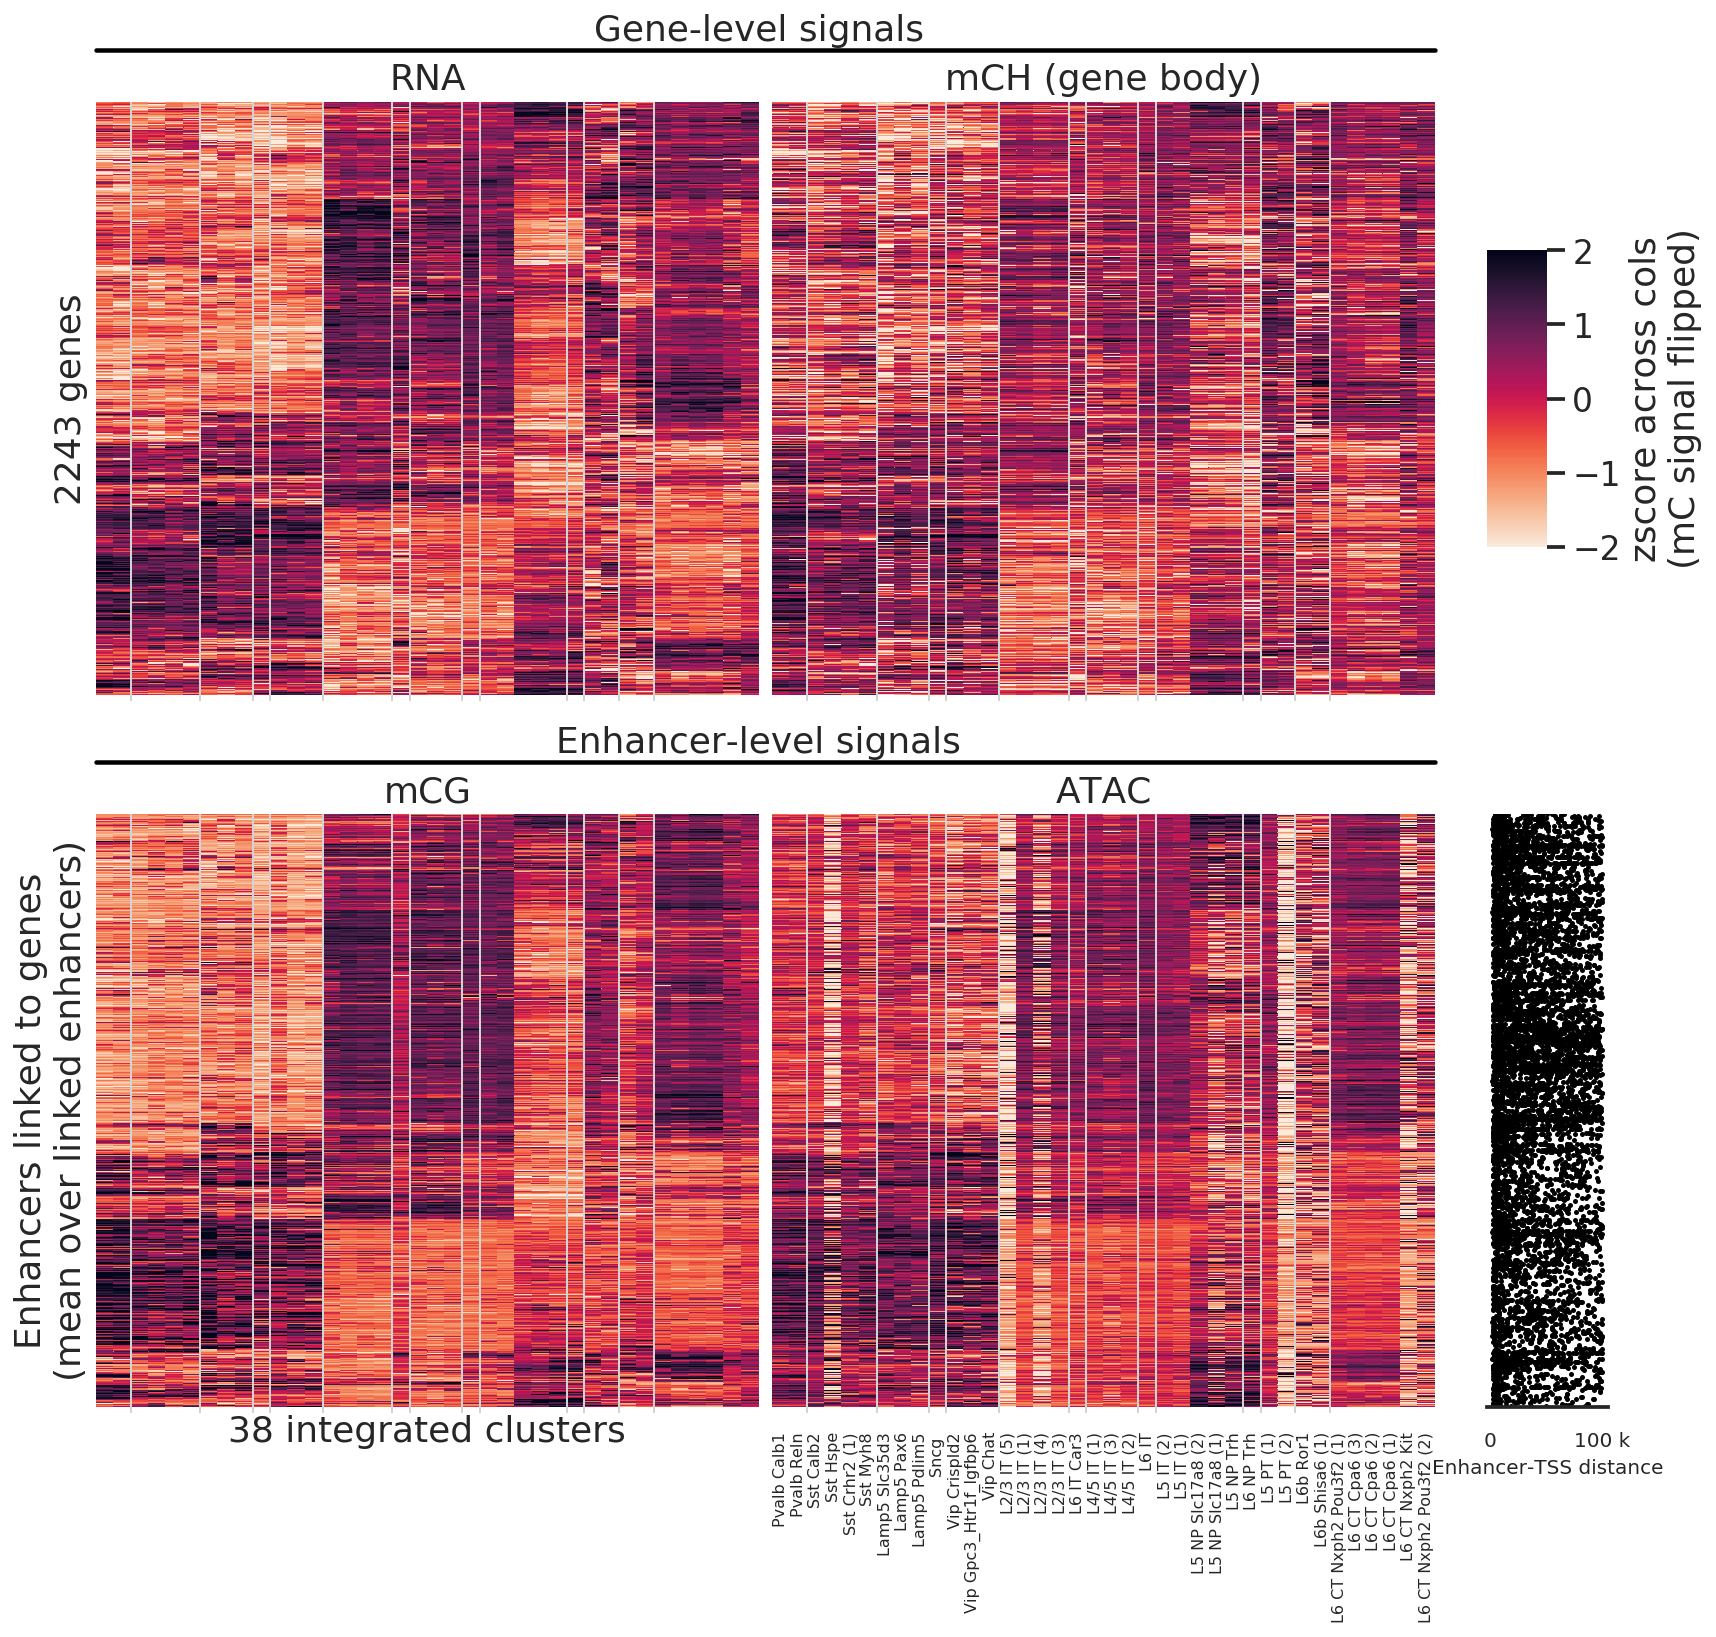

In [37]:
# heatmap of gene by cluster

# sign
cmap = 'rocket_r'
vmin, vmax = -2, 2
cbar_kws = {
    'fraction': 0.05, 
    'label': 'zscore across cols\n(mC signal flipped)',
    }

plot_mats = [rna_mat, -mch_mat, -mcg_mat, atac_mat]
labels = ['RNA', 'mCH (gene body)', 'mCG', 'ATAC']
row_labels = ['Gene-level signals', 'Enhancer-level signals']
figxoffset = 0.03 # last column left (figure fraction)
figyoffset = 0.03 # hline top heatmap (figure fraction)
    
# line breaks
clst_heads = [clst.split(' ')[0] for clst in clusters_selected_labels[col_idx]]
linepos = snmcseq_utils.get_breakpos_array(clst_heads)

# plot
with sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    # do it upfront
    fig.subplots_adjust(wspace=0.02, hspace=0.2)
    
    # cbar_ax
    pos = axs[0,1].get_position()
    x0, y0, w, h = pos.x0, pos.y0, pos.width, pos.height
    cbar_ax = fig.add_axes([x0+w+figxoffset, y0+h/4, 0.5*(1-(x0+w+figxoffset)), h/2])
    
    # dist_ax
    pos = axs[1,1].get_position()
    x0, y0, w, h = pos.x0, pos.y0, pos.width, pos.height
    dist_ax = fig.add_axes([x0+w+figxoffset, y0, 1-(x0+w+figxoffset), h])
    
    # heatmaps
    for i, (ax, mat, label) in enumerate(zip(
            axs.flat, plot_mats, labels)):
        
        # ticklabels
        if i == 3:
            xticklabels = clusters_selected_labels[col_idx]
            cbar = True
        else:
            xticklabels = False
            cbar = False
        
        g = sns.heatmap(mat.iloc[row_idx, col_idx],
                        xticklabels=xticklabels,
                        yticklabels=False,
                        cbar=cbar,
                        cbar_ax=cbar_ax,
                        cbar_kws=cbar_kws,
                        vmin=vmin, vmax=vmax,
                        cmap=cmap,
                        rasterized=True,
                        ax=ax)
        ax.set_title(label)
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # add line breaks
        ax.vlines(linepos, 0, 1.01*ngene, 
                  color='lightgray', zorder=2, 
                  linewidth=1, clip_on=False)
    
    # labels
    ax = axs[0,0]
    ax.set_ylabel('{} genes'.format(ngene))
    ax = axs[1,0]
    ax.set_ylabel('Enhancers linked to genes\n(mean over linked enhancers)')
    ax.set_xlabel('{} integrated clusters'.format(nclst))
    ax = axs[1,1]
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
    # distance panel
    ax = dist_ax
    ax.scatter(sig_dists, sig_genes_idx, s=1, c='black',
               rasterized=True,
              )
    sns.despine(ax=ax, left=True)
    ax.set_ylim([0, ngene])
    ax.set_yticklabels([])
    ax.invert_yaxis()
    ax.set_xticks([0, 1e5])
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Enhancer-TSS distance', fontsize=10)
    
    # row headers
    for ax, ax_right, row in zip(axs[:,0], axs[:,1], row_labels):
        # figure fraction
        pos = ax.get_position()
        x0, y0, w, h = pos.x0, pos.y0, pos.width, pos.height
        pos = ax_right.get_position()
        x0r, y0r, wr, hr = pos.x0, pos.y0, pos.width, pos.height
        ax.plot([x0,x0r+wr], [y0+h+figyoffset]*2, color='k', transform=fig.transFigure, clip_on=False)
        
        ax.annotate(row, 
                    xy=(1, 1), xycoords='axes fraction',
                    ha='center', va='bottom',
                    xytext=(0, 1.5*ax.title.get_fontsize()),
                    textcoords='offset points',
                   )
    
    snmcseq_utils.savefig(fig, output_figures.format('heatmap_siglinked_pairs.pdf'))
    plt.show()

### one example correlation

In [38]:
def plot_scatter_gene_enh(axg, axh, gene, enh, gene_name='', enh_name='',):
    """
    """
    fontsize = 10
    
    clsts = gene_rna_clsts.columns.values
    
    ax = axg
    _x = enh_mcg_clsts.loc[enh]
    _y = gene_rna_clsts.loc[gene]
#     print(_x.sort_values().index.tolist())
    ax.invert_xaxis()

    ax.scatter(_x.values, _y.values, c=mod_palette['mc'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
#     for __x, __y, __c in zip(_x, _y, _c):
#         _c = pd.Series(clst_annot)[clsts]
#         if __y > 1:
#             ax.text(__x, __y, __c, fontsize=fontsize)

    ax.set_xlabel('mCG')
    ax.set_ylabel('{} log10(TPM+1)'.format(gene_name))
    ax.annotate(enh_name, 
                xy=(1,0), xycoords='axes fraction',
                xytext=(0, -3*ax.xaxis.label.get_fontsize()),
                textcoords='offset points',
                ha='center', va='top',
               )

    ax = axh
    _x = enh_atac_clsts.loc[enh]
    _y = gene_rna_clsts.loc[gene]

    ax.scatter(_x.values, _y.values, c=mod_palette['atac'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
    
#     for __x, __y, __c in zip(_x, _y, _c):
#         _c = pd.Series(clst_annot)[clsts]
#         if __y > 1:
#             ax.text(__x, __y, __c, fontsize=fontsize)

    ax.set_xlabel('ATAC')
    ax.set_ylabel('')

    return 

In [39]:

print(gid_to_gname.shape)
print(gname_to_gid.shape)

(12095,)
(12095,)


In [40]:
res_corrs_comb = res_corrs.join(res2_corrs.set_index(['gene', 'enh', 'dist', 'is_in_genebody']), 
                                on=['gene', 'enh', 'dist', 'is_in_genebody'], 
                                lsuffix='_mc', rsuffix='_atac').astype({'enh': int})
res_corrs_comb['corr_both'] = res_corrs_comb['corr_mc'] + (-res_corrs_comb['corr_atac'])
res_corrs_comb = res_corrs_comb.sort_values('corr_both')
print(res_corrs_comb.shape)
res_corrs_comb.head()



(1710144, 11)


gene     enh   dist is_in_genebody   corr_mc  \
1070095  ENSMUSG00000039156  171584  55618          False -0.872634   
95295    ENSMUSG00000008489  160142  37984           True -0.904804   
1090712  ENSMUSG00000039706  170709   3839           True -0.918135   
1033533  ENSMUSG00000038256  146496   2401           True -0.866068   
1456069  ENSMUSG00000062078   97738   5126           True -0.910226   

         corr_shuff_mc  corr_shuff_cells_mc  corr_atac  corr_shuff_atac  \
1070095       0.598205            -0.129008   0.870883         0.680928   
95295         0.001204            -0.060510   0.838406        -0.177797   
1090712       0.362592             0.288607   0.816351         0.002736   
1033533       0.039282             0.234927   0.858413         0.027956   
1456069      -0.085833             0.096672   0.808627        -0.368037   

         corr_shuff_cells_atac  corr_both  
1070095              -0.229675  -1.743517  
95295                 0.126560  -1.743210  
1090712               0.046295  -1.734486  
1033533               0.014471  -1.724482  
1456069               0.290648  -1.718853

In [41]:
enh = 131993
res_corrs_comb[res_corrs_comb['enh']==enh].head(10)

gene     enh    dist is_in_genebody   corr_mc  \
568824   ENSMUSG00000027347  131993   45463          False -0.721414   
569305   ENSMUSG00000027351  131993  267090          False -0.686180   
568991   ENSMUSG00000027349  131993  138725          False -0.537367   
1574934  ENSMUSG00000085316  131993  488312          False -0.482000   
1107956  ENSMUSG00000040133  131993  984955          False  0.874385   

         corr_shuff_mc  corr_shuff_cells_mc  corr_atac  corr_shuff_atac  \
568824       -0.303863            -0.057446   0.746143        -0.614838   
569305       -0.232958            -0.099026   0.728417        -0.026808   
568991       -0.606522            -0.211949   0.593610        -0.219389   
1574934       0.383740            -0.234927   0.603677         0.816391   
1107956       0.362075             0.107999  -0.904366        -0.046504   

         corr_shuff_cells_atac  corr_both  
568824                0.189189  -1.467557  
569305                0.027684  -1.414597  
568991                0.044972  -1.130977  
1574934               0.134260  -1.085677  
1107956              -0.228143   1.778750

In [42]:
gene = gname_to_gid.loc['Slc1a2']
res_corrs_comb[res_corrs_comb['gene']==gene].head(10)

gene     enh    dist is_in_genebody   corr_mc  \
64992  ENSMUSG00000005089  130658  134251          False -0.717475   
64986  ENSMUSG00000005089  130646   82598           True -0.771529   
64982  ENSMUSG00000005089  130638   74436           True -0.771717   
64943  ENSMUSG00000005089  130580   58770          False -0.759315   
64991  ENSMUSG00000005089  130657  133594          False -0.658168   
64987  ENSMUSG00000005089  130649   84264           True -0.723524   
64969  ENSMUSG00000005089  130616   25421           True -0.846810   
64964  ENSMUSG00000005089  130610   19639           True -0.831491   
64968  ENSMUSG00000005089  130614   23514           True -0.844841   
64983  ENSMUSG00000005089  130639   75224           True -0.750739   

       corr_shuff_mc  corr_shuff_cells_mc  corr_atac  corr_shuff_atac  \
64992       0.081956             0.020243   0.829047        -0.009960   
64986      -0.021118             0.167524   0.750246         0.020247   
64982      -0.029686             0.020484   0.741406         0.072805   
64943      -0.108005             0.154949   0.744173        -0.250246   
64991       0.003830             0.029215   0.844588         0.093576   
64987      -0.204339             0.103726   0.759221        -0.076064   
64969      -0.035562            -0.022212   0.621196         0.051566   
64964       0.034249             0.142795   0.613221        -0.271533   
64968      -0.065981            -0.028778   0.594260         0.007777   
64983      -0.111500             0.126600   0.661266         0.061419   

       corr_shuff_cells_atac  corr_both  
64992              -0.133195  -1.546521  
64986              -0.114589  -1.521775  
64982              -0.215021  -1.513123  
64943              -0.168180  -1.503488  
64991              -0.131444  -1.502756  
64987              -0.127722  -1.482745  
64969              -0.221042  -1.468006  
64964              -0.145890  -1.444712  
64968              -0.142294  -1.439101  
64983              -0.170790  -1.412004

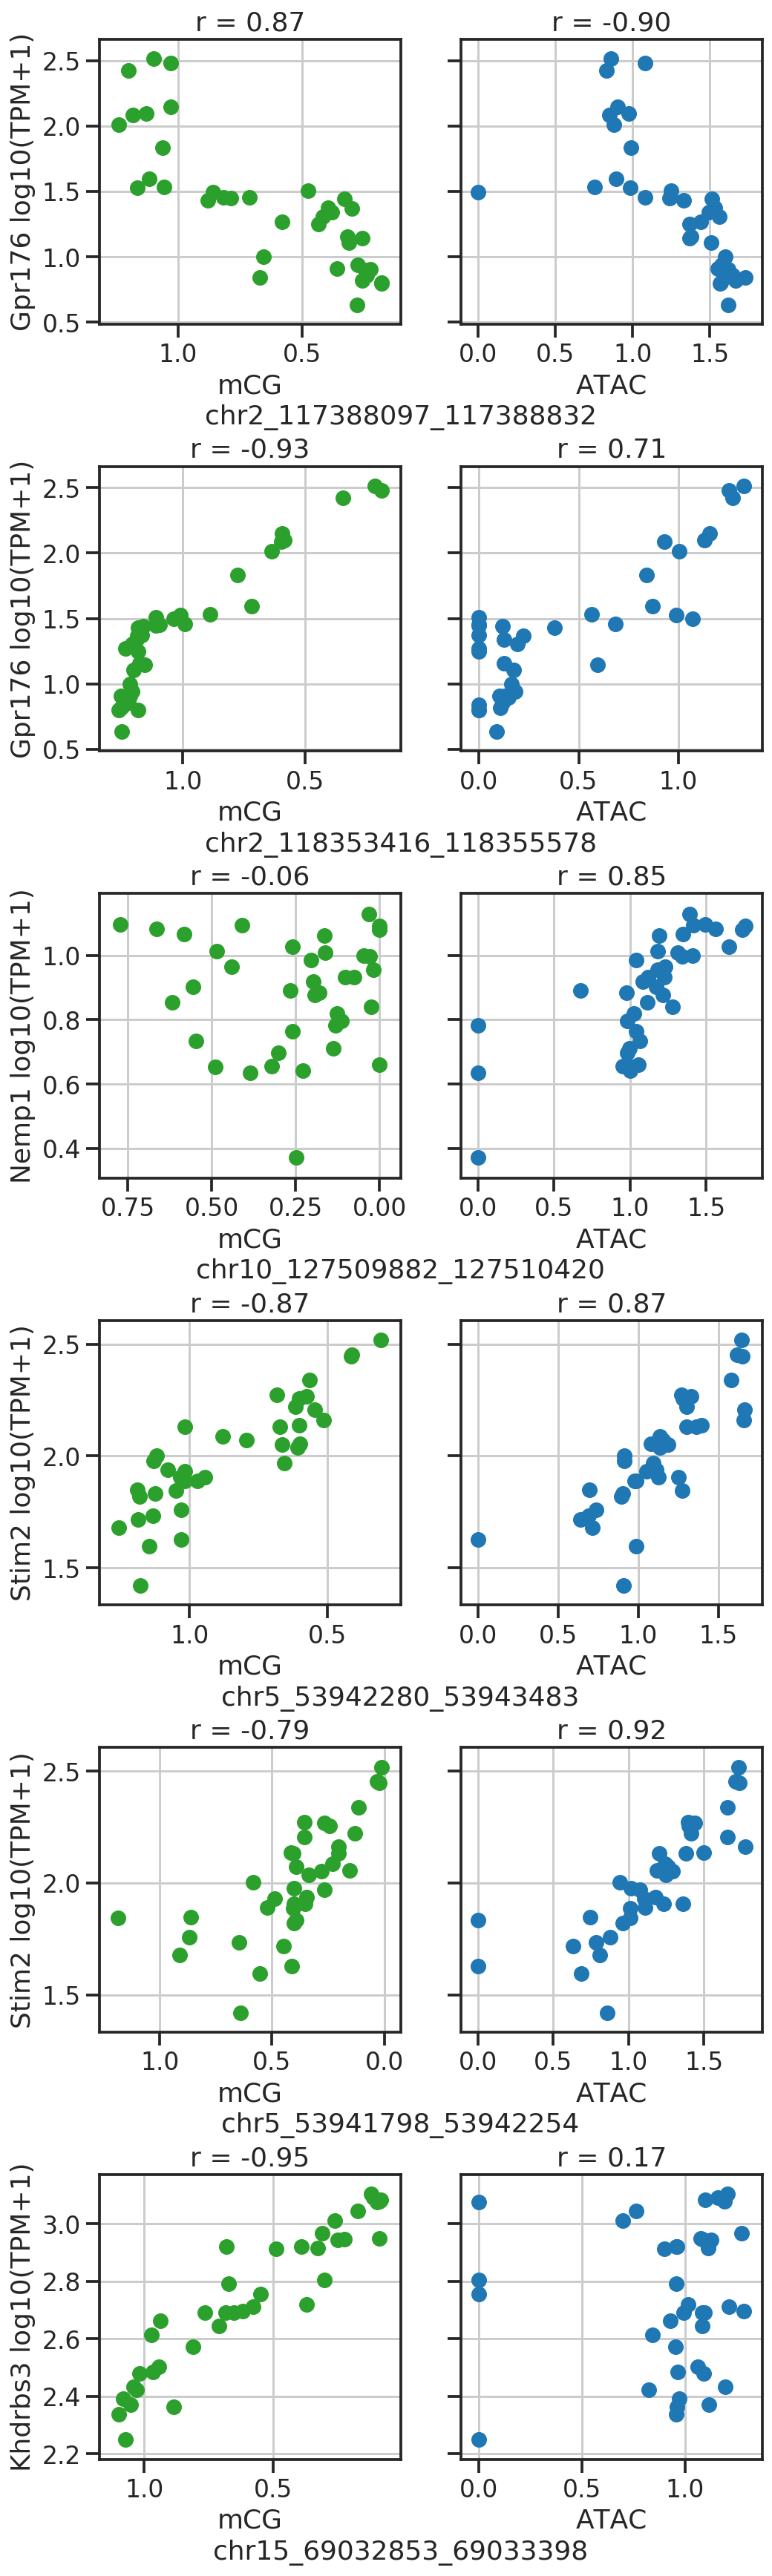

In [43]:
gene_enh_pairs = [
    ('ENSMUSG00000040133', 131993),
    ('ENSMUSG00000040133', 132088),
    ('ENSMUSG00000040195', 30489),
    ('ENSMUSG00000039156', 171584),
    ('ENSMUSG00000039156', 171583),
    ('ENSMUSG00000022332', 83016),
]

n = len(gene_enh_pairs)
fig, axs = plt.subplots(n, 2, figsize=(4*2,5*n), sharey='row')
fig.subplots_adjust(hspace=0.5)
for ax_row, (gene, enh) in zip(axs, gene_enh_pairs):
    gene_name = gid_to_gname.loc[gene]
    enh_name = '_'.join(enh_list.set_index('index').loc[enh][
                        ['chr', 'start', 'end']].astype(str).tolist())
    plot_scatter_gene_enh(ax_row[0], ax_row[1], gene, enh, gene_name, enh_name,)
plt.show()


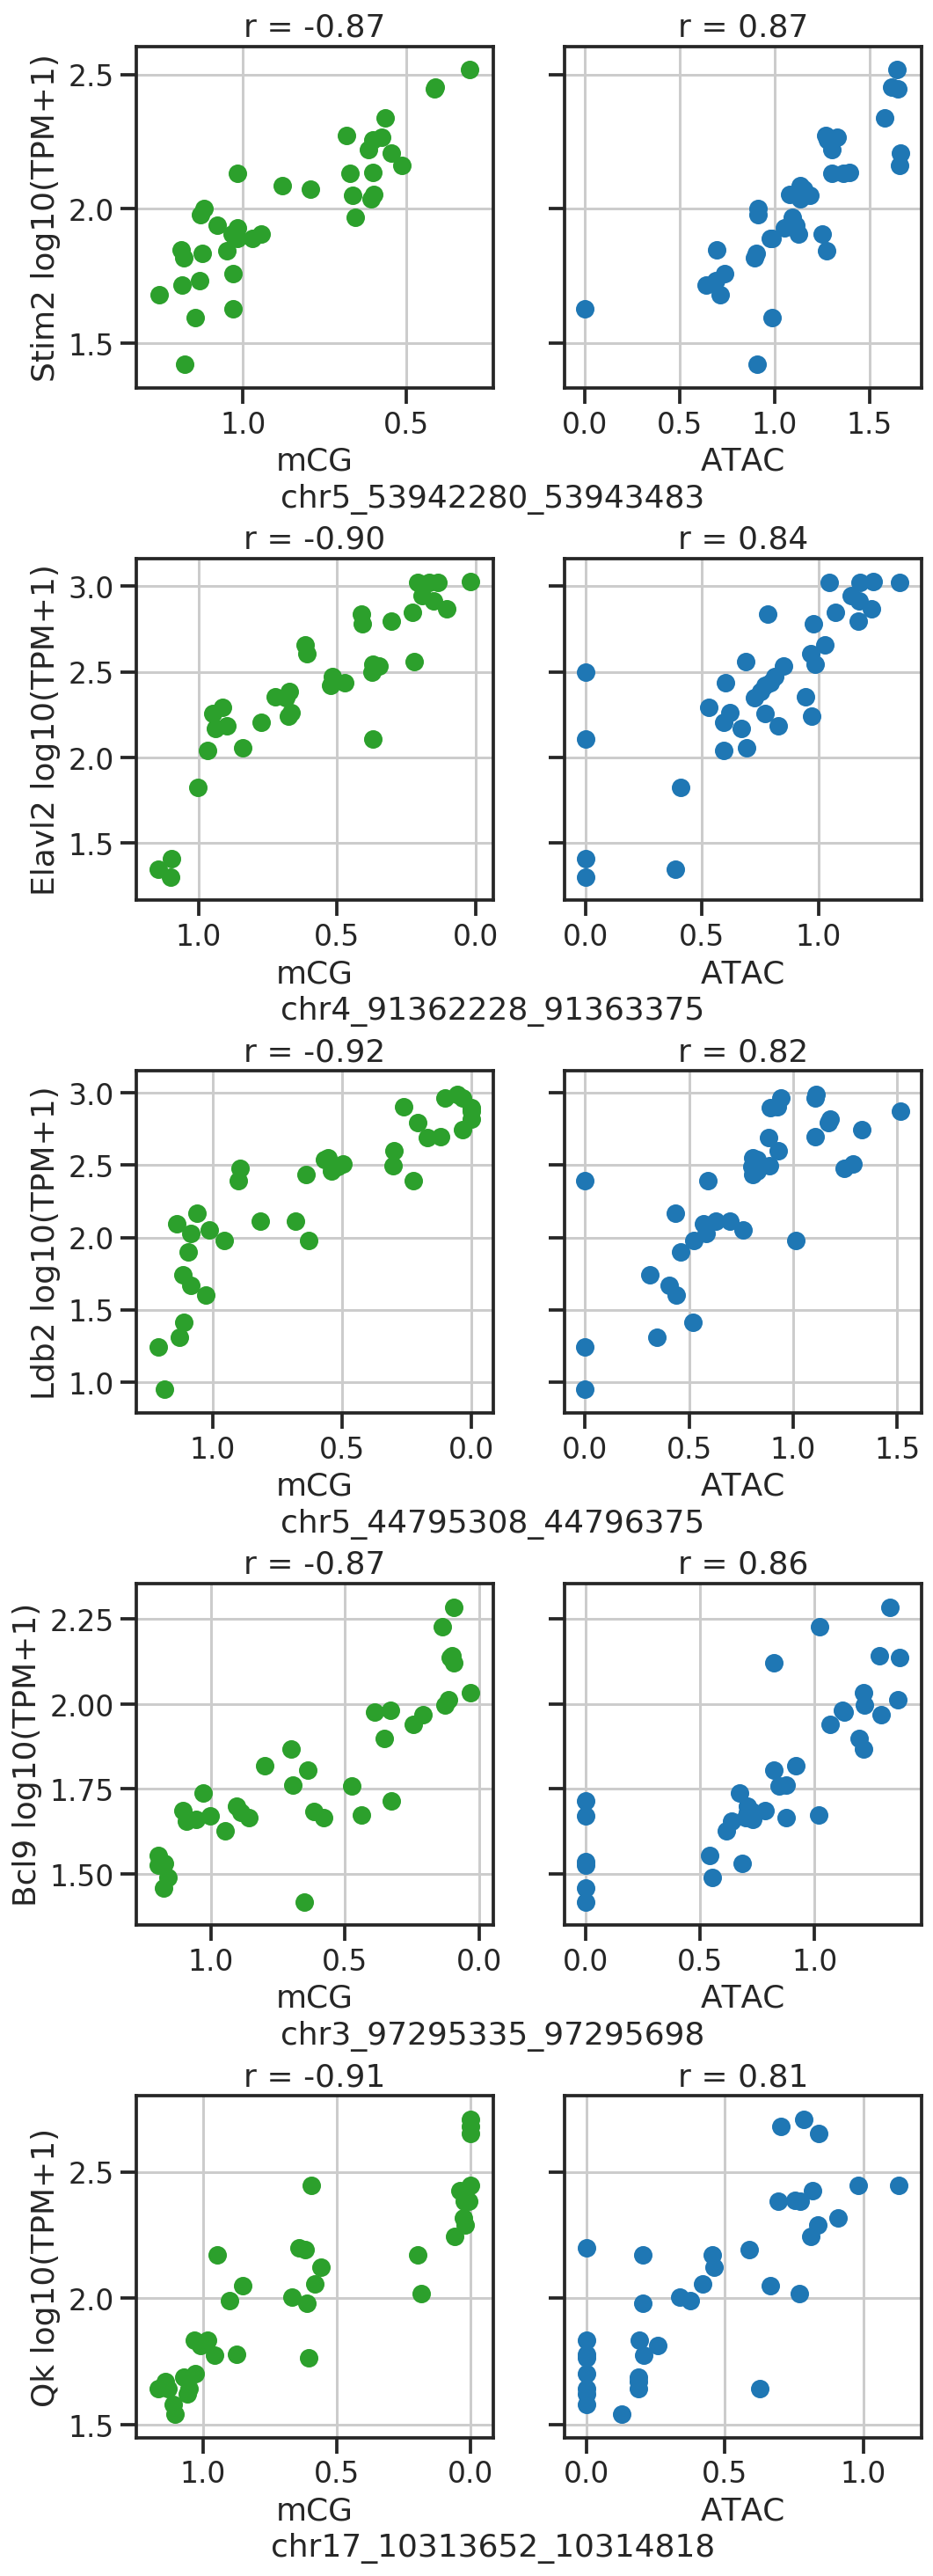

In [44]:
n = 5 

fig, axs = plt.subplots(n, 2, figsize=(4*2,5*n), sharey='row')
fig.subplots_adjust(hspace=0.5)
for i, (idx, row) in enumerate(res_corrs_comb.head(n).iterrows()):
    ax_row = axs[i]
    gene = row['gene']
    enh = row['enh']
    
    gene_name = gid_to_gname.loc[gene]
    enh_name = '_'.join(enh_list.set_index('index').loc[enh][
                        ['chr', 'start', 'end']].astype(str).tolist())
    plot_scatter_gene_enh(ax_row[0], ax_row[1], gene, enh, gene_name, enh_name,)
plt.show()

### Compare with nearest gene 

In [45]:
def strip_gid_suffix(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

In [46]:
# get nn gene information
df_nngene = res_stats['linked_table'].copy()
df_nngene['mod'] = 'mc'

# add is_in_genebody
df_nngene = pd.merge(df_nngene, 
                     to_evals[['gene', 'enh', 'is_in_genebody']], 
                     on=['gene', 'enh'],
                     how='left')
# add is_nearest_gene
df_nngene['nearest_gene'] = (enh_list_expand.set_index('index')
                                            .reindex(df_nngene['enh'].values.astype(int))
                                            ['gene_id']
                                            .apply(strip_gid_suffix)
                                            .values
                            )
df_nngene['is_nearest_gene'] = (df_nngene['gene'] == df_nngene['nearest_gene'])
# add is_cicero
df_nngene = pd.merge(df_nngene, enh_gene_links_cicero.reset_index().rename(columns={'index': 'is_cicero'}), 
                     on=['gene', 'enh'], 
                     how='left',
                    )
df_nngene['is_cicero'] = ~np.isnan(df_nngene['is_cicero'])

n_linked = len(df_nngene)
n_nngene = df_nngene['is_nearest_gene'].sum()
print("{}/{}={:.2f} pairs are from the nearest genes"
      .format(n_nngene, n_linked, n_nngene/n_linked))


df2_nngene = res2_stats['linked_table'].copy()
df2_nngene['mod'] = 'atac'
# add is_in_genebody
df2_nngene = pd.merge(df2_nngene, 
                      to_evals[['gene', 'enh', 'is_in_genebody']], 
                      on=['gene', 'enh'],
                      how='left')
# add is_nearest_gene
df2_nngene['nearest_gene'] = (enh_list_expand.set_index('index')
                                             .reindex(df2_nngene['enh'].values.astype(int))
                                             ['gene_id']
                                             .apply(strip_gid_suffix)
                                             .values
                            )
df2_nngene['is_nearest_gene'] = (df2_nngene['gene'] == df2_nngene['nearest_gene'])
# add is_cicero
df2_nngene = pd.merge(df2_nngene, enh_gene_links_cicero.reset_index().rename(columns={'index': 'is_cicero'}), 
                     on=['gene', 'enh'], 
                     how='left',
                    )
df2_nngene['is_cicero'] = ~np.isnan(df2_nngene['is_cicero'])

n_linked = len(df2_nngene)
n_nngene = df2_nngene['is_nearest_gene'].sum()
print("{}/{}={:.2f} pairs are from the nearest genes"
      .format(n_nngene, n_linked, n_nngene/n_linked))

3978/7528=0.53 pairs are from the nearest genes
2024/3978=0.51 pairs are from the nearest genes


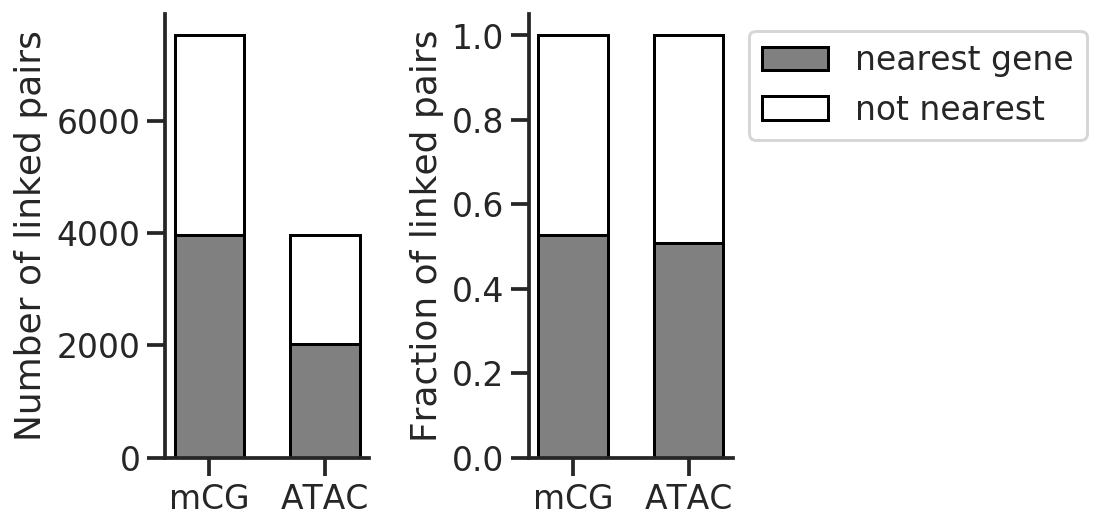

In [47]:
# numbers 
track1 = [0, 
          len(df_nngene[df_nngene['is_nearest_gene'].values]),
          len(df_nngene[~df_nngene['is_nearest_gene'].values]), 
         ]
track2 = [0, 
          len(df2_nngene[df2_nngene['is_nearest_gene'].values]),
          len(df2_nngene[~df2_nngene['is_nearest_gene'].values]), 
         ]
colors = ['gray', 'white']
labels = ['nearest gene', 'not nearest']
ax_labels = ['Number of linked pairs', 
             'Fraction of linked pairs', 
            ]

with sns.axes_style({
#                      'patch.force_edgecolor': False,
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    fig, axs = plt.subplots(1, 2, figsize=(4*2,4))
    for j, (ax, ax_label) in enumerate(zip(axs, ax_labels)):
        if j == 1:
            # normalize 
            track1 = np.array(track1)
            track1 = track1/track1.sum()

            track2 = np.array(track2)
            track2 = track2/track2.sum()

        for i in range(len(track1)-1):
            color = colors[i]
            ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=labels[i])
        for i in range(len(track2)-1):
            color = colors[i]
            ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=labels[i])

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['mCG', 'ATAC'])
        ax.set_ylabel(ax_label)
        sns.despine(ax=ax)

    snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
    # fig.suptitle('', fontsize=16)
    fig.tight_layout()

    snmcseq_utils.savefig(fig, output_figures.format('bar_frac_nngene.pdf'))

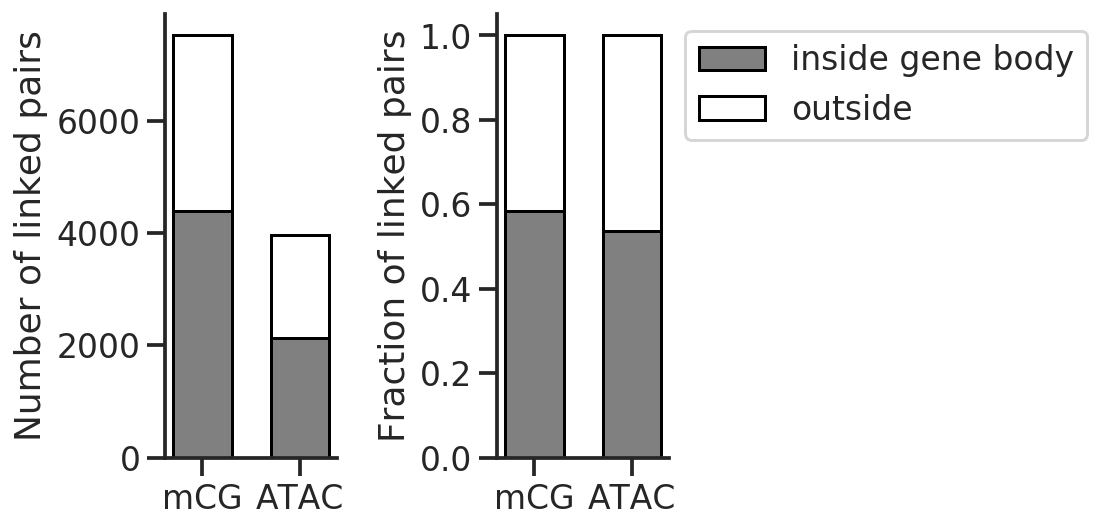

In [48]:
# numbers 
track1 = [0, 
          len(df_nngene[df_nngene['is_in_genebody'].values]),
          len(df_nngene[~df_nngene['is_in_genebody'].values]), 
         ]
track2 = [0, 
          len(df2_nngene[df2_nngene['is_in_genebody'].values]),
          len(df2_nngene[~df2_nngene['is_in_genebody'].values]), 
         ]
colors = ['gray', 'white']
labels = ['inside gene body', 'outside']
ax_labels = ['Number of linked pairs', 
             'Fraction of linked pairs', 
            ]

with sns.axes_style({
#                      'patch.force_edgecolor': False,
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    fig, axs = plt.subplots(1, 2, figsize=(4*2,4))
    for j, (ax, ax_label) in enumerate(zip(axs, ax_labels)):
        if j == 1:
            # normalize 
            track1 = np.array(track1)
            track1 = track1/track1.sum()

            track2 = np.array(track2)
            track2 = track2/track2.sum()

        for i in range(len(track1)-1):
            color = colors[i]
            ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=labels[i])
        for i in range(len(track2)-1):
            color = colors[i]
            ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=labels[i])

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['mCG', 'ATAC'])
        ax.set_ylabel(ax_label)
        sns.despine(ax=ax)

    snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
    # fig.suptitle('', fontsize=16)
    fig.tight_layout()

    snmcseq_utils.savefig(fig, output_figures.format('bar_frac_ingene.pdf'))

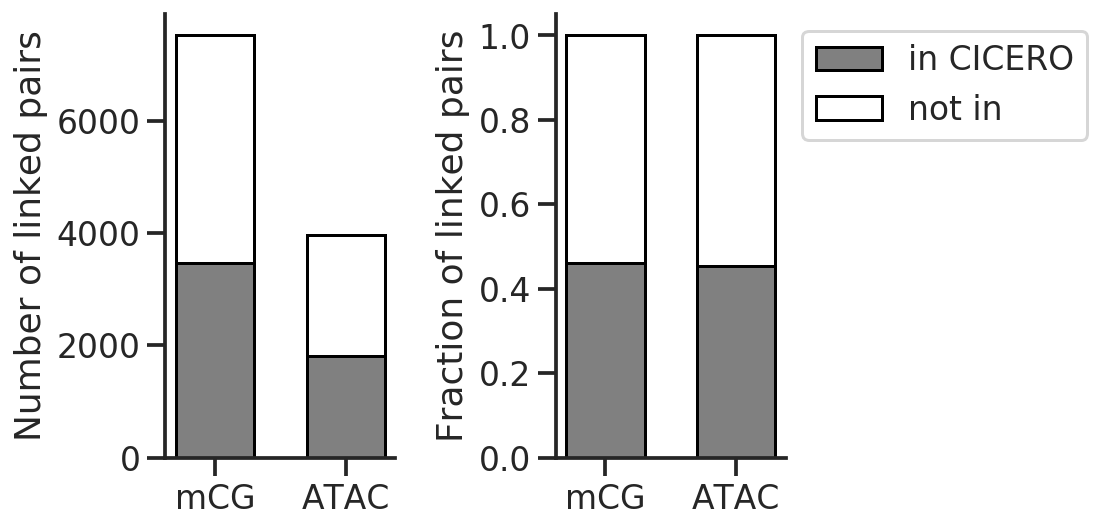

In [49]:
# numbers 
track1 = [0, 
          len(df_nngene[df_nngene['is_cicero'].values]),
          len(df_nngene[~df_nngene['is_cicero'].values]), 
         ]
track2 = [0, 
          len(df2_nngene[df2_nngene['is_cicero'].values]),
          len(df2_nngene[~df2_nngene['is_cicero'].values]), 
         ]
colors = ['gray', 'white']
labels = ['in CICERO', 'not in']
ax_labels = ['Number of linked pairs', 
             'Fraction of linked pairs', 
            ]

with sns.axes_style({
#                      'patch.force_edgecolor': False,
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    fig, axs = plt.subplots(1, 2, figsize=(4*2,4))
    for j, (ax, ax_label) in enumerate(zip(axs, ax_labels)):
        if j == 1:
            # normalize 
            track1 = np.array(track1)
            track1 = track1/track1.sum()

            track2 = np.array(track2)
            track2 = track2/track2.sum()

        for i in range(len(track1)-1):
            color = colors[i]
            ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=labels[i])
        for i in range(len(track2)-1):
            color = colors[i]
            ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=labels[i])

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['mCG', 'ATAC'])
        ax.set_ylabel(ax_label)
        sns.despine(ax=ax)

    snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
    # fig.suptitle('', fontsize=16)
    fig.tight_layout()

    snmcseq_utils.savefig(fig, output_figures.format('bar_frac_incicero.pdf'))

### 2D density ATAC vs mC

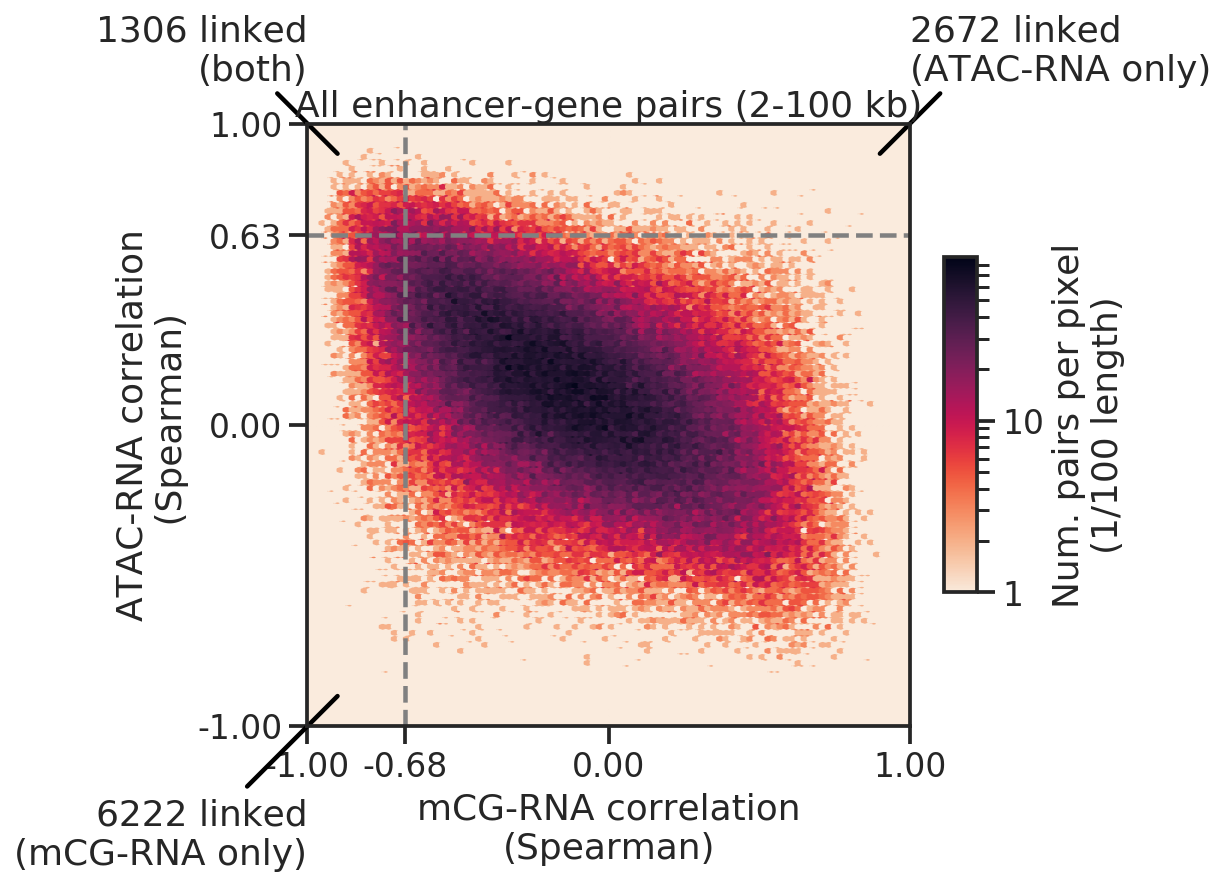

In [50]:
# prep
_table = res_corrs_comb[res_corrs_comb['dist']<1e5]
_x = _table['corr_mc'].values
_y = _table['corr_atac'].values
r_mc, r_atac = res_stats['r_th_linked'], ATAC_SIGN*res2_stats['r_th_linked'] #-0.5, 0.5
# cond_mc = _table['corr_mc'] < r_mc
# cond_atac = _table['corr_atac'] > r_atac

sets = [
    set(res_stats['linked_table'].index.values),
    set(res2_stats['linked_table'].index.values),
]
num_sig_both = len(sets[0] & sets[1])
num_sig_mc = len(sets[0]) - num_sig_both
num_sig_atac = len(sets[1]) - num_sig_both

# plot
fig, ax = plt.subplots(figsize=(6, 6))
g = ax.hexbin(_x, _y,  
              gridsize=(100,100),
              extent=(-1,1,-1,1),
              cmap='rocket_r', 
              bins='log', # log10(i+1)
              rasterized=True,
             )
ax.axhline(r_atac, color='gray', linestyle='--', zorder=2)
ax.axvline(r_mc, color='gray', linestyle='--', zorder=2)
ax.set_aspect('equal')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])  
ax.set_xticks(np.sort([-1, 0, 1, r_mc]))
ax.set_yticks(np.sort([-1, 0, 1, r_atac]))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
ax.set_xlabel('mCG-RNA correlation\n(Spearman)')
ax.set_ylabel('ATAC-RNA correlation\n (Spearman)')
ax.set_title('All enhancer-gene pairs (2-100 kb)', pad=0)

# annotate
ax.annotate("{} linked\n(mCG-RNA only)".format(num_sig_mc), 
            xy=(0,0), xycoords='axes fraction',
            xytext=(0, -2*ax.xaxis.label.get_fontsize()), textcoords='offset points',
            ha='right', va='top',
            fontsize=ax.title.get_fontsize(),
           )
ax.annotate("{} linked\n(ATAC-RNA only)".format(num_sig_atac), 
            xy=(1,1), xycoords='axes fraction',
            xytext=(0, +ax.title.get_fontsize()), textcoords='offset points',
            ha='left', va='bottom',
            fontsize=ax.title.get_fontsize(),
           )
ax.annotate("{} linked\n(both)".format(num_sig_both), 
            xy=(0,1), xycoords='axes fraction',
            xytext=(0, +ax.title.get_fontsize()), textcoords='offset points',
            ha='right', va='bottom',
            fontsize=ax.title.get_fontsize(),
           )

# lines
ax.plot([-1.2,-0.9], [-1.2, -0.9], color='k', clip_on=False)
ax.plot([1.1,0.9], [1.1, 0.9], color='k', clip_on=False)
ax.plot([-1.1,-0.9], [1.1, 0.9], color='k', clip_on=False)


# cbar
cbar = fig.colorbar(g, ax=ax, 
                     fraction=0.05, aspect=10,
                     label='Num. pairs per pixel\n(1/100 length)')
cbar.ax.yaxis.set_major_formatter(mtick.EngFormatter())
snmcseq_utils.savefig(fig, output_figures.format('scatter_corr_mcrna_atacrna.pdf'))
plt.show()

### Nums enhancer vs nums genes 

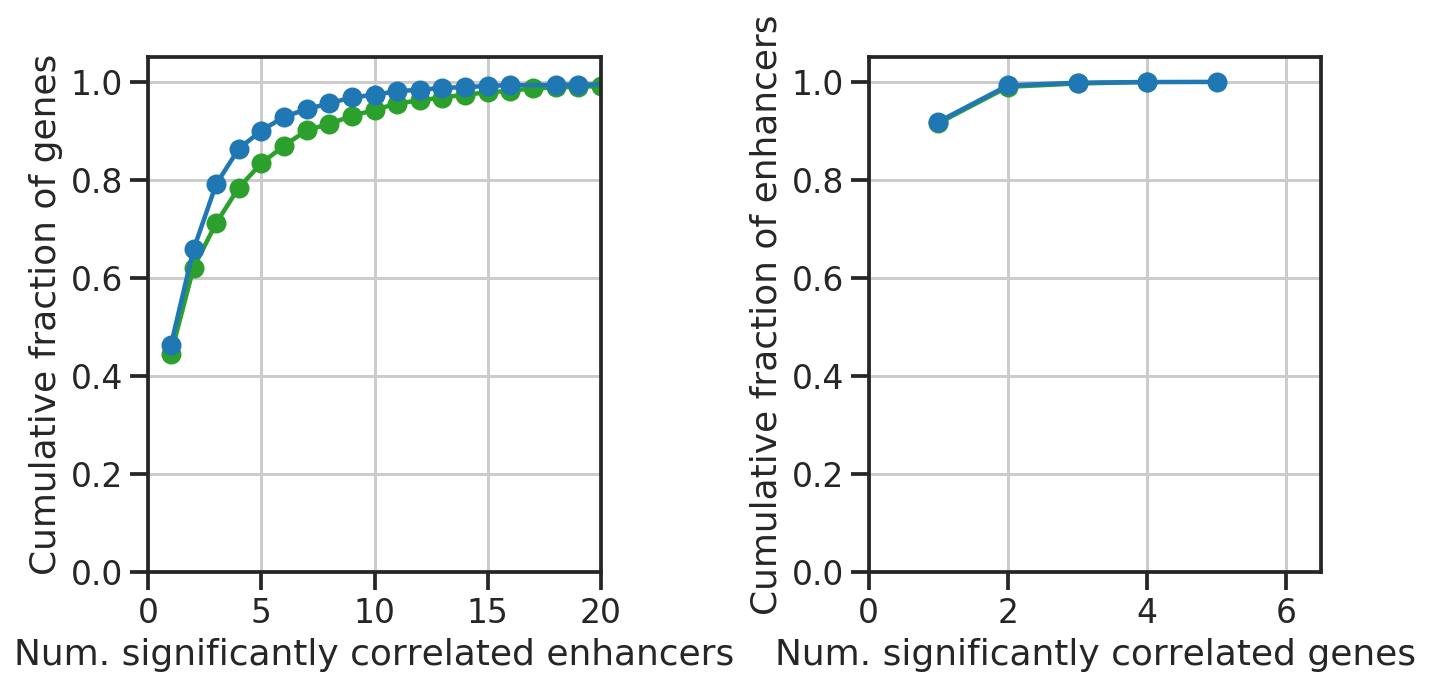

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1))
ax = axs[0]
for mod, _df in zip(['mc', 'atac'], 
                    [df_nngene, df2_nngene], 
                    ):
    a = _df.groupby('gene').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated enhancers')
ax.set_ylabel('Cumulative fraction of genes')
ax.set_xlim([0, 20])
ax.set_ylim([0, 1.05])

ax = axs[1]
for mod, _df in zip(['mc', 'atac'], 
                    [df_nngene, df2_nngene], 
                    ):
    a = _df.groupby('enh').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated genes')
ax.set_ylabel('Cumulative fraction of enhancers')
ax.set_xlim([0, 6.5])
ax.set_ylim([0, 1.05])



fig.tight_layout()
fig.savefig(output_figures.format('cdf_gene_enh_num_dist.pdf'), bbox_inches='tight')

### stacked barplot -- num enh linked by mCG-RNA vs by ATAC-RNA 

In [52]:
a = df_nngene.groupby('gene').size().sort_values(ascending=False)
b = df2_nngene.groupby('gene').size().sort_values(ascending=False)
c = pd.merge(df_nngene, df2_nngene, 
         on=['gene', 'enh'], 
         ).groupby('gene').size().sort_values(ascending=False)

linked_genes_summary = (pd.concat([a, b, c], axis=1)
                            .rename(columns={0:'mCG', 1:'ATAC', 2:'both'})
                            .fillna(0).astype(int)
                       )
linked_genes_summary['either'] = linked_genes_summary[['mCG', 'ATAC']].sum(axis=1) - linked_genes_summary['both']
linked_genes_summary['mCG only'] = linked_genes_summary['mCG'] - linked_genes_summary['both']
linked_genes_summary['ATAC only'] = linked_genes_summary['ATAC'] - linked_genes_summary['both']
linked_genes_summary = linked_genes_summary.sort_values('either', ascending=False)
linked_genes_summary.index = gid_to_gname[linked_genes_summary.index] 
print(linked_genes_summary.shape)
linked_genes_summary.head()

(2790, 6)


mCG  ATAC  both  either  mCG only  ATAC only
gene_name                                              
Bcl11b      45    23    19      49        26          4
Khdrbs3     47     2     2      47        45          0
Atp2b1      46     4     3      47        43          1
Afap1       34    24    18      40        16          6
Grik3       34    15     9      40        25          6

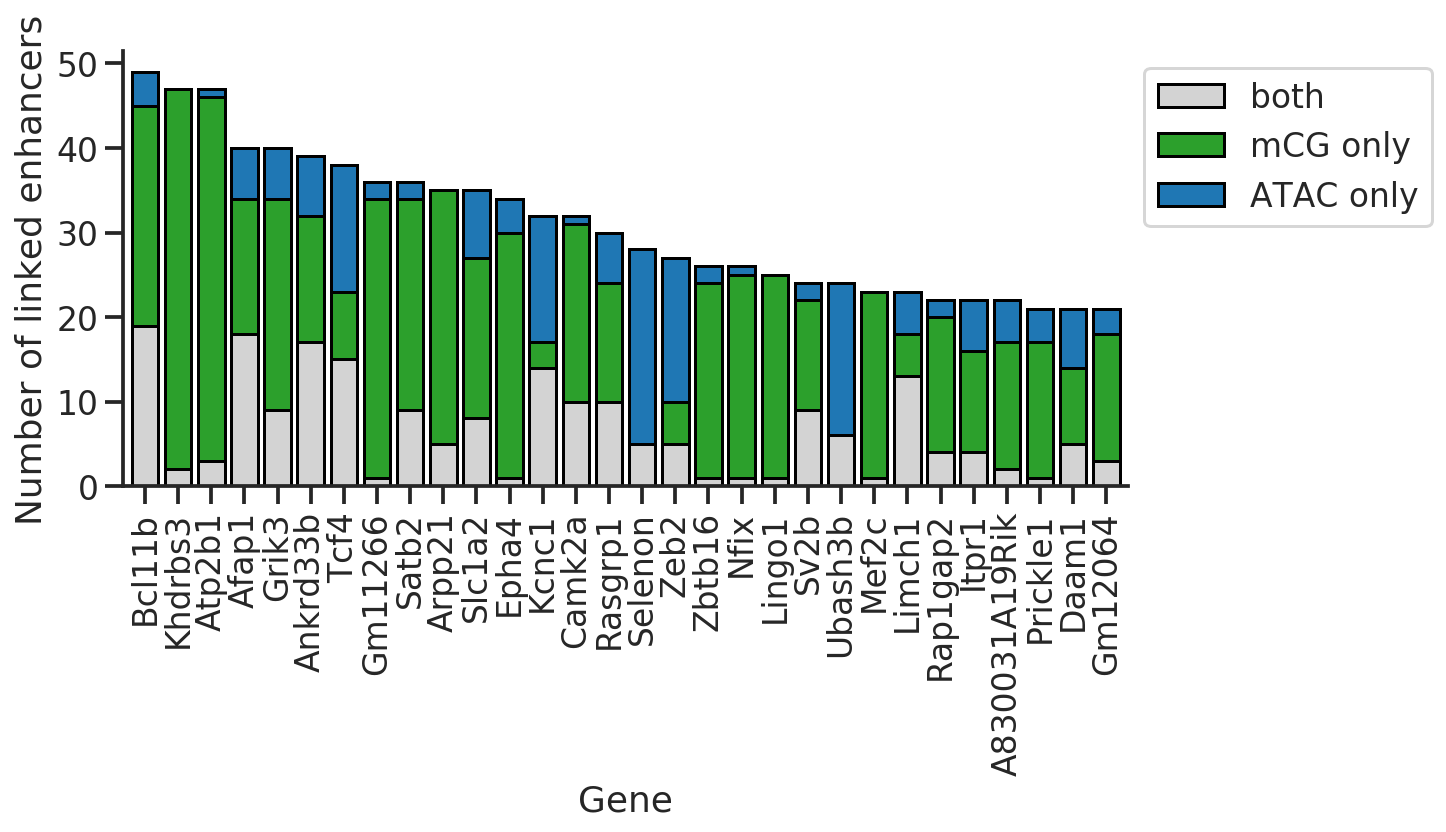

In [53]:
# numbers 
cols = ['both', 'mCG only', 'ATAC only'] 
colors = ['lightgray', mod_palette['mc'], mod_palette['atac']]
with sns.axes_style({
#                      'patch.force_edgecolor': False,
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    fig, ax = plt.subplots(figsize=(9,4))
    (linked_genes_summary[cols]
             .head(30)
             .plot.bar(stacked=True, width=0.8, alpha=1, ax=ax, color=colors)
        )
    ax.set_xlabel('Gene')
    ax.set_ylabel('Number of linked enhancers')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    sns.despine(ax=ax)
    snmcseq_utils.savefig(fig, output_figures.format('bar_gene_num_enh_mc_atac_both.pdf'))
    plt.show()

### stacked barplot -- intra- vs inter-genic 

In [54]:
a = (df_nngene.groupby(['gene', 'is_in_genebody']).size().unstack().fillna(0).astype(int)
              .rename(columns={False: "mCG 0", True: "mCG 1"}) 
    )
b = (df2_nngene.groupby(['gene', 'is_in_genebody']).size().unstack().fillna(0).astype(int)
               .rename(columns={False: "ATAC 0", True: "ATAC 1"}) 
    )
c = (pd.merge(df_nngene, df2_nngene, 
         on=['gene', 'enh'])
         .groupby(['gene', 'is_in_genebody_x']).size().unstack().fillna(0).astype(int)
         .rename(columns={False: "both 0", True: "both 1"}) 
    )

linked_genes_summary_detail = pd.concat([a, b, c], axis=1).fillna(0).astype(int) #.rename(columns={False: 'cC'})
print(linked_genes_summary_detail.shape)
linked_genes_summary_detail.head()

(2790, 6)


mCG 0  mCG 1  ATAC 0  ATAC 1  both 0  both 1
ENSMUSG00000000058      1      0       0       0       0       0
ENSMUSG00000000088      1      0       0       0       0       0
ENSMUSG00000000126      2      5       0       0       0       0
ENSMUSG00000000142      0      1       0       0       0       0
ENSMUSG00000000326      1      0       0       0       0       0

In [55]:
linked_genes_summary_detail['either 0'] = (linked_genes_summary_detail[['mCG 0', 'ATAC 0']].sum(axis=1) 
                                           - linked_genes_summary_detail['both 0']
                                          )
linked_genes_summary_detail['either 1'] = (linked_genes_summary_detail[['mCG 1', 'ATAC 1']].sum(axis=1) 
                                           - linked_genes_summary_detail['both 1']
                                          )
linked_genes_summary_detail['either'] = linked_genes_summary_detail['either 0'] + linked_genes_summary_detail['either 1']

linked_genes_summary_detail['mCG only 0'] = linked_genes_summary_detail['mCG 0'] - linked_genes_summary_detail['both 0']
linked_genes_summary_detail['mCG only 1'] = linked_genes_summary_detail['mCG 1'] - linked_genes_summary_detail['both 1']

linked_genes_summary_detail['ATAC only 0'] = linked_genes_summary_detail['ATAC 0'] - linked_genes_summary_detail['both 0']
linked_genes_summary_detail['ATAC only 1'] = linked_genes_summary_detail['ATAC 1'] - linked_genes_summary_detail['both 1']


linked_genes_summary_detail = linked_genes_summary_detail.sort_values('either', ascending=False)
linked_genes_summary_detail.index = gid_to_gname[linked_genes_summary_detail.index] 
print(linked_genes_summary_detail.shape)
linked_genes_summary_detail.head()

(2790, 13)


mCG 0  mCG 1  ATAC 0  ATAC 1  both 0  both 1  either 0  either 1  \
gene_name                                                                     
Bcl11b         3     42       1      22       1      18         3        46   
Atp2b1         1     45       0       4       0       3         1        46   
Khdrbs3        1     46       0       2       0       2         1        46   
Afap1          1     33       0      24       0      18         1        39   
Grik3          4     30       7       8       2       7         9        31   

           either  mCG only 0  mCG only 1  ATAC only 0  ATAC only 1  
gene_name                                                            
Bcl11b         49           2          24            0            4  
Atp2b1         47           1          42            0            1  
Khdrbs3        47           1          44            0            0  
Afap1          40           1          15            0            6  
Grik3          40           2          23            5            1

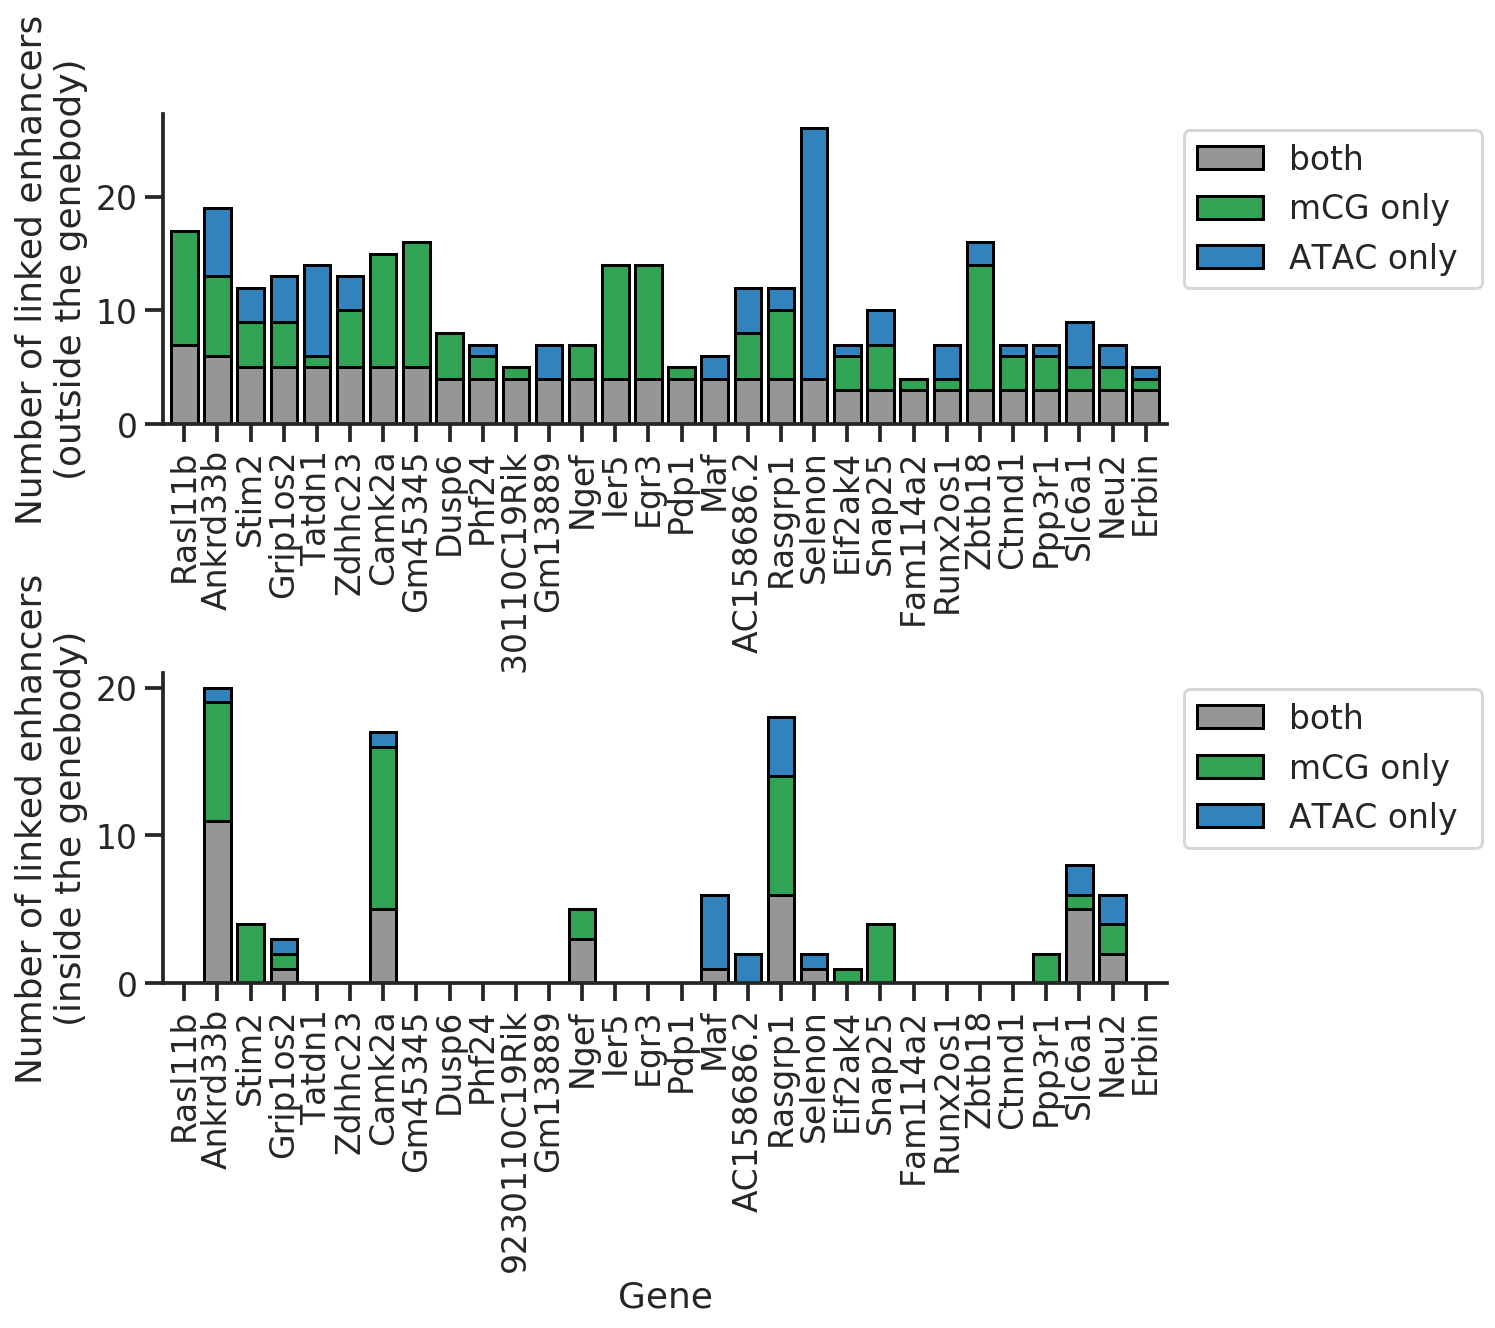

In [56]:
# numbers 
import matplotlib

# cols = ['both 0', 'both 1', 
#         'mCG only 0', 'mCG only 1', 
#         'ATAC only 0', 'ATAC only 1',
#        ] 
# colors = [
#           mod_palette_comp['null'][2], mod_palette_comp['null'][3],
#           mod_palette_comp['mc'][0], mod_palette_comp['mc'][2], 
#           mod_palette_comp['atac'][0], mod_palette_comp['atac'][2], 
#          ]

cols_all = [ 
    ['both 0', 'mCG only 0', 'ATAC only 0',], 
    ['both 1', 'mCG only 1', 'ATAC only 1',], 
]
titles_all = ['outside the genebody', 'inside the genebody']
colors = [
          mod_palette_comp['null'][2], 
          mod_palette_comp['mc'][0], 
          mod_palette_comp['atac'][0], 
         ]
df_plot = linked_genes_summary_detail.sort_values('both 0', ascending=False)

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    r = EMPTY_RECTANGLE
    
    fig, axs = plt.subplots(2, 1, figsize=(9,4*2))
    for ax, cols, title in zip(axs, cols_all, titles_all):
        (df_plot[cols]
                .head(30)
                .plot.bar(stacked=True, width=0.8, alpha=1, ax=ax, color=colors)
            )
        ax.set_xlabel('Gene')
        ax.set_ylabel('Number of linked enhancers\n({})'.format(title))
        sns.despine(ax=ax)

        # work on the legends
        handles, labels = ax.get_legend_handles_labels()
        labels = [label.strip("01") for label in labels]
        ax.legend(handles, labels, 
                  bbox_to_anchor=(1,1), loc='upper left', ncol=1, 
                 )
    fig.subplots_adjust(hspace=0.8)
    snmcseq_utils.savefig(fig, output_figures.format('bar_gene_num_enh_mc_atac_both_inout_gene.pdf'))
    plt.show()